In [26]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [27]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
print(torchvision.__version__)

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.11.0 True
0.12.0
0.22.1


In [28]:
# verify installation and cuda running
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [30]:
from torchvision import datasets, models, transforms
import torch.optim as optim

if torch.cuda.is_available():
    torch.cuda.init()
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    cuda = torch.device('cuda')
    cuda0 = torch.device('cuda:0')
    print(cuda0)

0
1
1024
2097152
cuda:0


/home/user/anaconda3/envs/python37/lib/python3.7/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [31]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1024 B  |    3584 B  |   11264 B  |   10240 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |    1024 B  |    3584 B  |   11264 B  |   10240 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |    1024 B  |    3584 B  |   11264 B  |   10240 B  |\n|       from large pool |       0 B  |       0 B  |

In [32]:
torch.cuda.empty_cache()

In [33]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [34]:
import os.path as osp
import numpy as np
from PIL import Image
import skimage
from skimage import io
print(skimage.__version__)

0.18.3


In [35]:
import mmcv

In [36]:
mmcv.__version__

'1.4.8'

In [37]:
classes = ['background', 'human']
palette = [[0,0,0], [255,0,0]]
class_weight = [1.0, 6.0] # 0.13 human pixels

In [38]:
import os.path as osp
import mmcv
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset


@DATASETS.register_module()
class HumanDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette

    def __init__(self, **kwargs):
        super(HumanDataSet, self).__init__(**kwargs)
        assert osp.exists(self.img_dir)

    def results2img(self, results, imgfile_prefix, to_label_id, indices=None):
        if indices is None:
            indices = list(range(len(self)))

        mmcv.mkdir_or_exist(imgfile_prefix)
        result_files = []
        for result, idx in zip(results, indices):

            filename = self.img_infos[idx]['filename']
            basename = osp.splitext(osp.basename(filename))[0]

            png_filename = osp.join(imgfile_prefix, f'{basename}.png')

            output = Image.fromarray(result.astype(np.uint8))
            output.save(png_filename)
            result_files.append(png_filename)

        return result_files

    def format_results(self,
                       results,
                       imgfile_prefix,
                       to_label_id=True,
                       indices=None):
        
        if indices is None:
            indices = list(range(len(self)))

        assert isinstance(results, list), 'results must be a list.'
        assert isinstance(indices, list), 'indices must be a list.'

        result_files = self.results2img(results, imgfile_prefix, to_label_id,
                                        indices)
        return result_files

KeyError: 'HumanDataSet is already registered in dataset'

In [39]:
from mmcv import Config
cfg = Config.fromfile('../configs/bisenetv1/bisenetv1_r18-d32_lr5e-3_4x4_512x512_160k_coco-stuff164k.py')

In [40]:
data_root = '../data/NewBinaryDataSet/binaryAnnotationsMIX30WithNoHuman/'
img_dir = 'humanImages'
ann_dir = 'binaryAnnotations'

In [41]:
context_channels=(128, 256, 512)
spatial_channels=(64, 64, 64, 128)

In [42]:
decode_head_loss_weight = 1.0
auxiliary_head_loss_weight = decode_head_loss_weight*0.4

In [43]:
norm_config_type = 'BN'

In [44]:
from mmseg.apis import set_random_seed
# Since we use ony one GPU, BN is used instead of BN
cfg.norm_cfg = dict(type=norm_config_type, requires_grad=True)  # Segmentation usually uses SyncBN
# model settings
cfg.model = dict(
    type='EncoderDecoder', # Name of segmentor
    pretrained=None,
    backbone=dict(
        type='BiSeNetV1', # The type of backbone.
        in_channels=3,
        context_channels=context_channels,
        spatial_channels=spatial_channels,
        out_indices=(0, 1, 2),
        out_channels=256,
        backbone_cfg=dict(
            type='ResNet',
            in_channels=3,
            depth=18,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=cfg.norm_cfg,
            norm_eval=False,
            style='pytorch',
            contract_dilation=True),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        init_cfg=None
    ),
    decode_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=0,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=len(classes),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        loss_decode=[ 
            dict( # Config of loss function for the decode_head.
                type='CrossEntropyLoss', # Type of loss used for segmentation.
                loss_name='loss_ce',
                use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                loss_weight=decode_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                #class_weight=class_weight
            ),
            dict( # Config of loss function for the decode_head.
                type='DiceLoss', # Type of loss used for segmentation.
                loss_name='loss_dice',
                use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                loss_weight=decode_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                class_weight=class_weight
            )
        ]
    ),
    auxiliary_head=[
        dict(
            type='FCNHead', # Type of auxiliary head. Please refer to mmseg/models/decode_heads for available options.
            in_channels=128, # Input channel of auxiliary head.
            channels=64, # The intermediate channels of decode head.
            num_convs=1, # Number of convs in FCNHead. It is usually 1 in auxiliary head.
            num_classes=len(classes), # Number of segmentation class. Usually 19 for cityscapes, 21 for VOC, 150 for ADE20k.
            in_index=1, # The index of feature map to select.
            norm_cfg=cfg.norm_cfg, # The configuration of norm layer.
            concat_input=False, # The configuration of norm layer.
            align_corners=False, # The align_corners argument for resize in decoding.
            loss_decode=[ 
                dict( # Config of loss function for the decode_head.
                    type='CrossEntropyLoss', # Type of loss used for segmentation.
                    loss_name='loss_ce',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=decode_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    class_weight=class_weight
                )
            ]
        ),
        dict(
            type='FCNHead',
            in_channels=128,
            channels=64,
            num_convs=1,
            num_classes=len(classes),
            in_index=2,
            norm_cfg=cfg.norm_cfg,
            concat_input=False,
            align_corners=False,
            loss_decode=[ 
                dict( # Config of loss function for the decode_head.
                    type='CrossEntropyLoss', # Type of loss used for segmentation.
                    loss_name='loss_ce',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=decode_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    class_weight=class_weight
                )
            ]
        )
    ],
    # model training and testing settings
    train_cfg=dict(),  # train_cfg is just a place holder for now.
    test_cfg=dict(mode='whole') # The test mode, options are 'whole' and 'sliding'. 'whole': whole image fully-convolutional test. 'sliding': sliding crop window on the image.
)  

In [45]:
############### start dataset 
cfg.dataset_type = 'HumanDataSet'  # Dataset type, this will be used to define the dataset.
cfg.data_root = data_root  # Root path of data.
cfg.img_norm_cfg = dict(  # Image normalization config to normalize the input images.
    mean=[123.675, 116.28, 103.53],  # Mean values used to pre-training the pre-trained backbone models.
    std=[58.395, 57.12, 57.375],  # Standard variance used to pre-training the pre-trained backbone models.
    to_rgb=True)  # The channel orders of image used to pre-training the pre-trained backbone models.
cfg.crop_size = (512, 512)  # The crop size during training.

cfg.train_pipeline = [  # Training pipeline.
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path.
    dict(type='LoadAnnotations', reduce_zero_label=False),  # Second pipeline to load annotations for current image.
    dict(type='Resize',  # Augmentation pipeline that resize the images and their annotations.
        img_scale=(2048, 512),  # The largest scale of image.
        ratio_range=(0.5, 2.0)), # The augmented scale range as ratio.
    dict(type='RandomCrop',  # Augmentation pipeline that randomly crop a patch from current image.
        crop_size=cfg.crop_size,  # The crop size of patch.
        cat_max_ratio=0.75),  # The max area ratio that could be occupied by single category.
    dict(
        type='RandomFlip',  # Augmentation pipeline that flip the images and their annotations
        flip_ratio=0.5),  # The ratio or probability to flip
    dict(type='PhotoMetricDistortion'),  # Augmentation pipeline that distort current image with several photo metric methods.
    dict(
        type='Normalize',  # Augmentation pipeline that normalize the input images
        **cfg.img_norm_cfg),
    dict(type='Pad',  # Augmentation pipeline that pad the image to specified size.
        size=cfg.crop_size,  # The output size of padding.
        pad_val=0,  # The padding value for image.
        seg_pad_val=255),  # The padding value of 'gt_semantic_seg'.
    dict(type='DefaultFormatBundle'),  # Default format bundle to gather data in the pipeline
    dict(type='Collect',  # Pipeline that decides which keys in the data should be passed to the segmentor
        keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='MultiScaleFlipAug',  # An encapsulation that encapsulates the test time augmentations
        img_scale=(2048, 512),  # Decides the largest scale for testing, used for the Resize pipeline
        flip=False,  # Whether to flip images during testing
        transforms=[
            dict(type='Resize',  # Use resize augmentation
                 keep_ratio=True),  # Whether to keep the ratio between height and width, the img_scale set here will be suppressed by the img_scale set above.
            dict(type='RandomFlip'),  # Thought RandomFlip is added in pipeline, it is not used when flip=False
            dict(
                type='Normalize',  # Normalization config, the values are from img_norm_cfg
                 **cfg.img_norm_cfg),
            dict(type='ImageToTensor', # Convert image to tensor
                keys=['img']),
            dict(type='Collect', # Collect pipeline that collect necessary keys for testing.
                keys=['img'])
        ])
]
cfg.data = dict(
    samples_per_gpu=8,
    workers_per_gpu=8,
    train=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/training',
        ann_dir=f'{ann_dir}/training',
        pipeline=cfg.train_pipeline),
    val=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline),
    test=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline))
############ end dataset

In [46]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
#print(datasets[0].CLASSES)
print(len(datasets[0].CLASSES))

2022-04-05 17:20:09,067 - mmseg - INFO - Loaded 86365 images


2


In [47]:
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(datasets[0].CLASSES)
cfg.model.auxiliary_head[0].num_classes = len(datasets[0].CLASSES)
cfg.model.auxiliary_head[1].num_classes = len(datasets[0].CLASSES)

In [63]:
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/testv1.augmented_dataset.160000iter.earlystoping'

############ start default runtime
cfg.log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        dict(type='TensorboardLoggerHook'),  # The Tensorboard logger is also supported
        dict(type='TextLoggerHook', by_epoch=True)
    ]
)
cfg.dist_params = dict(backend='nccl')  # Parameters to setup distributed training, the port can also be set.
cfg.log_level = 'INFO'  # The level of logging.
cfg.load_from = None  # load models as a pre-trained model from a given path. This will not resume training.
cfg.resume_from = None  # Resume checkpoints from a given path, the training will be resumed from the iteration when the checkpoint's is saved.
cfg.workflow = [('train', 1)]  # , ('val', 1) Workflow for runner. [('train', 1)] means there is only one workflow and the workflow named 'train' is executed once. The workflow trains the model by 40000 iterations according to the `runner.max_iters`.
cfg.cudnn_benchmark = True  # Whether use cudnn_benchmark to speed up, which is fast for fixed input size.
############ end default runtime

############ start schedule
cfg.optimizer = dict(  # Config used to build optimizer, support all the optimizers in PyTorch whose arguments are also the same as those in PyTorch
    type='SGD',  # Type of optimizers, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
    lr=0.01,  # Learning rate of optimizers, see detail usages of the parameters in the documentation of PyTorch
    momentum=0.9,  # Momentum
    weight_decay=0.0005,
    #paramwise_cfg=dict(
    #    custom_keys=dict(head=dict(lr_mult=10.0)))
)
cfg.optimizer_config = dict()  # Config used to build the optimizer hook, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/optimizer.py#L8 for implementation details.
cfg.lr_config = dict(
    policy='poly',  # The policy of scheduler, also support Step, CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    power=0.9,
    min_lr=0.00001,  # The minimum learning rate to stable the training.
    by_epoch=True,
    warmup='linear',
    warmup_iters=1,
    warmup_ratio=0.1,
    warmup_by_epoch=True
)
#cfg.momentum_config = dict(
#    policy='LinearAnnealing',
#    min_momentum=0.1,
#    by_epoch=True,
#    warmup='linear',
#    warmup_iters=1,
#    warmup_ratio=0.9
#)
cfg.runner=dict(
    type='EpochBasedRunner', # Type of runner to use (i.e. IterBasedRunner or EpochBasedRunner)
    max_epochs=25
)
cfg.checkpoint_config = dict(  # Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
    by_epoch=True,  # Whether count by epoch or not.
    interval=2,
    meta=dict(
        CLASSES=classes,
        PALETTE=palette
    )
)
cfg.evaluation = dict(  # The config to build the evaluation hook. Please refer to mmseg/core/evaluation/eval_hook.py for details.
    interval=1,  # The interval of evaluation.
    metric='mIoU',
    pre_eval=True,
    early_stopping=True,
    max_epochs=2
)

############ end schedule

In [64]:
# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='BiSeNetV1',
        in_channels=3,
        context_channels=(128, 256, 512),
        spatial_channels=(64, 64, 64, 128),
        out_indices=(0, 1, 2),
        out_channels=256,
        backbone_cfg=dict(
            type='ResNet',
            in_channels=3,
            depth=18,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=dict(type='BN', requires_grad=True),
            norm_eval=False,
            style='pytorch',
            contract_dilation=True),
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        init_cfg=None),
    decode_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=0,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropo

In [65]:
# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [66]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [67]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-04-05 17:27:53,887 - mmseg - INFO - Loaded 4807 images
2022-04-05 17:27:53,888 - mmseg - INFO - Start running, host: user@ESWS-VT02-01, work_dir: /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping
2022-04-05 17:27:53,888 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(HIGH        ) CosineAnnealingMomentumUpdaterHook 
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(HIGH        ) CosineAnnealingMomentumUpdaterHook 
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook         

2022-04-05 17:32:51,128 - mmseg - INFO - Epoch [1][1000/10795]	lr: 1.833e-03, eta: 22:10:53, time: 0.294, data_time: 0.006, memory: 2044, decode.loss_ce: 0.9216, decode.acc_seg: 61.6458, aux_0.loss_ce: 0.9300, aux_0.acc_seg: 62.4404, aux_1.loss_ce: 0.9326, aux_1.acc_seg: 61.5775, loss: 2.7842
2022-04-05 17:33:05,751 - mmseg - INFO - Epoch [1][1050/10795]	lr: 1.875e-03, eta: 22:09:40, time: 0.292, data_time: 0.006, memory: 2044, decode.loss_ce: 0.9305, decode.acc_seg: 65.3485, aux_0.loss_ce: 0.9298, aux_0.acc_seg: 66.8981, aux_1.loss_ce: 0.9473, aux_1.acc_seg: 64.9976, loss: 2.8077
2022-04-05 17:33:20,332 - mmseg - INFO - Epoch [1][1100/10795]	lr: 1.916e-03, eta: 22:08:22, time: 0.292, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8813, decode.acc_seg: 61.8587, aux_0.loss_ce: 0.8873, aux_0.acc_seg: 63.3626, aux_1.loss_ce: 0.8933, aux_1.acc_seg: 62.5718, loss: 2.6619
2022-04-05 17:33:34,904 - mmseg - INFO - Epoch [1][1150/10795]	lr: 1.958e-03, eta: 22:07:08, time: 0.291, data_time: 0

2022-04-05 17:39:38,843 - mmseg - INFO - Epoch [1][2400/10795]	lr: 3.000e-03, eta: 21:48:57, time: 0.291, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8968, decode.acc_seg: 64.0385, aux_0.loss_ce: 0.9024, aux_0.acc_seg: 63.6736, aux_1.loss_ce: 0.9055, aux_1.acc_seg: 63.1274, loss: 2.7046
2022-04-05 17:39:53,364 - mmseg - INFO - Epoch [1][2450/10795]	lr: 3.042e-03, eta: 21:48:25, time: 0.290, data_time: 0.006, memory: 2044, decode.loss_ce: 0.9063, decode.acc_seg: 64.0761, aux_0.loss_ce: 0.9283, aux_0.acc_seg: 63.3660, aux_1.loss_ce: 0.9193, aux_1.acc_seg: 63.6548, loss: 2.7539
2022-04-05 17:40:07,881 - mmseg - INFO - Epoch [1][2500/10795]	lr: 3.083e-03, eta: 21:47:53, time: 0.290, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8127, decode.acc_seg: 70.3113, aux_0.loss_ce: 0.8214, aux_0.acc_seg: 70.2622, aux_1.loss_ce: 0.8161, aux_1.acc_seg: 69.8235, loss: 2.4502
2022-04-05 17:40:22,378 - mmseg - INFO - Epoch [1][2550/10795]	lr: 3.125e-03, eta: 21:47:20, time: 0.290, data_time: 0

2022-04-05 17:46:24,731 - mmseg - INFO - Epoch [1][3800/10795]	lr: 4.167e-03, eta: 21:36:03, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7754, decode.acc_seg: 70.5410, aux_0.loss_ce: 0.7849, aux_0.acc_seg: 71.3524, aux_1.loss_ce: 0.7844, aux_1.acc_seg: 71.4981, loss: 2.3446
2022-04-05 17:46:39,235 - mmseg - INFO - Epoch [1][3850/10795]	lr: 4.209e-03, eta: 21:35:41, time: 0.290, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8452, decode.acc_seg: 64.5035, aux_0.loss_ce: 0.8562, aux_0.acc_seg: 64.3485, aux_1.loss_ce: 0.8605, aux_1.acc_seg: 64.7392, loss: 2.5619
2022-04-05 17:46:53,726 - mmseg - INFO - Epoch [1][3900/10795]	lr: 4.251e-03, eta: 21:35:18, time: 0.290, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8244, decode.acc_seg: 70.2807, aux_0.loss_ce: 0.8325, aux_0.acc_seg: 70.3402, aux_1.loss_ce: 0.8332, aux_1.acc_seg: 70.6847, loss: 2.4902
2022-04-05 17:47:08,197 - mmseg - INFO - Epoch [1][3950/10795]	lr: 4.292e-03, eta: 21:34:54, time: 0.289, data_time: 0

2022-04-05 17:53:10,088 - mmseg - INFO - Epoch [1][5200/10795]	lr: 5.335e-03, eta: 21:26:00, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7954, decode.acc_seg: 70.7524, aux_0.loss_ce: 0.8001, aux_0.acc_seg: 70.6051, aux_1.loss_ce: 0.8124, aux_1.acc_seg: 70.1967, loss: 2.4079
2022-04-05 17:53:24,550 - mmseg - INFO - Epoch [1][5250/10795]	lr: 5.376e-03, eta: 21:25:39, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7993, decode.acc_seg: 67.1558, aux_0.loss_ce: 0.8087, aux_0.acc_seg: 66.1298, aux_1.loss_ce: 0.8243, aux_1.acc_seg: 64.9343, loss: 2.4323
2022-04-05 17:53:39,010 - mmseg - INFO - Epoch [1][5300/10795]	lr: 5.418e-03, eta: 21:25:19, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8472, decode.acc_seg: 70.5268, aux_0.loss_ce: 0.8545, aux_0.acc_seg: 70.0797, aux_1.loss_ce: 0.8806, aux_1.acc_seg: 69.6396, loss: 2.5824
2022-04-05 17:53:53,463 - mmseg - INFO - Epoch [1][5350/10795]	lr: 5.460e-03, eta: 21:24:58, time: 0.289, data_time: 0

2022-04-05 17:59:54,809 - mmseg - INFO - Epoch [1][6600/10795]	lr: 6.502e-03, eta: 21:16:55, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8117, decode.acc_seg: 68.8806, aux_0.loss_ce: 0.8180, aux_0.acc_seg: 68.8557, aux_1.loss_ce: 0.8332, aux_1.acc_seg: 68.1181, loss: 2.4628
2022-04-05 18:00:09,259 - mmseg - INFO - Epoch [1][6650/10795]	lr: 6.543e-03, eta: 21:16:36, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7893, decode.acc_seg: 71.0771, aux_0.loss_ce: 0.8085, aux_0.acc_seg: 70.4143, aux_1.loss_ce: 0.8229, aux_1.acc_seg: 69.9083, loss: 2.4207
2022-04-05 18:00:23,706 - mmseg - INFO - Epoch [1][6700/10795]	lr: 6.585e-03, eta: 21:16:18, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7880, decode.acc_seg: 71.2570, aux_0.loss_ce: 0.7948, aux_0.acc_seg: 70.4914, aux_1.loss_ce: 0.8054, aux_1.acc_seg: 70.6487, loss: 2.3883
2022-04-05 18:00:38,157 - mmseg - INFO - Epoch [1][6750/10795]	lr: 6.627e-03, eta: 21:15:59, time: 0.289, data_time: 0

2022-04-05 18:06:39,255 - mmseg - INFO - Epoch [1][8000/10795]	lr: 7.669e-03, eta: 21:08:30, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7835, decode.acc_seg: 68.7511, aux_0.loss_ce: 0.7856, aux_0.acc_seg: 68.7703, aux_1.loss_ce: 0.7959, aux_1.acc_seg: 68.1052, loss: 2.3650
2022-04-05 18:06:53,702 - mmseg - INFO - Epoch [1][8050/10795]	lr: 7.711e-03, eta: 21:08:13, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8086, decode.acc_seg: 70.5487, aux_0.loss_ce: 0.8226, aux_0.acc_seg: 70.1897, aux_1.loss_ce: 0.8224, aux_1.acc_seg: 70.4632, loss: 2.4536
2022-04-05 18:07:08,153 - mmseg - INFO - Epoch [1][8100/10795]	lr: 7.752e-03, eta: 21:07:56, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.8273, decode.acc_seg: 70.4897, aux_0.loss_ce: 0.8346, aux_0.acc_seg: 69.7225, aux_1.loss_ce: 0.8510, aux_1.acc_seg: 68.6632, loss: 2.5129
2022-04-05 18:07:22,596 - mmseg - INFO - Epoch [1][8150/10795]	lr: 7.794e-03, eta: 21:07:39, time: 0.289, data_time: 0

2022-04-05 18:13:23,401 - mmseg - INFO - Epoch [1][9400/10795]	lr: 8.836e-03, eta: 21:00:27, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7672, decode.acc_seg: 74.5113, aux_0.loss_ce: 0.7803, aux_0.acc_seg: 73.3470, aux_1.loss_ce: 0.7727, aux_1.acc_seg: 72.8519, loss: 2.3202
2022-04-05 18:13:37,832 - mmseg - INFO - Epoch [1][9450/10795]	lr: 8.878e-03, eta: 21:00:10, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7749, decode.acc_seg: 69.3029, aux_0.loss_ce: 0.7841, aux_0.acc_seg: 68.3458, aux_1.loss_ce: 0.7872, aux_1.acc_seg: 67.7657, loss: 2.3462
2022-04-05 18:13:52,259 - mmseg - INFO - Epoch [1][9500/10795]	lr: 8.919e-03, eta: 20:59:53, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7426, decode.acc_seg: 72.7565, aux_0.loss_ce: 0.7406, aux_0.acc_seg: 73.2871, aux_1.loss_ce: 0.7498, aux_1.acc_seg: 72.3479, loss: 2.2330
2022-04-05 18:14:06,677 - mmseg - INFO - Epoch [1][9550/10795]	lr: 8.961e-03, eta: 20:59:36, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 57.9 task/s, elapsed: 83s, ETA:     0s

2022-04-05 18:21:28,911 - mmseg - INFO - per class results:
2022-04-05 18:21:28,912 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 70.59 |  71.3 |
|   human    | 33.01 | 93.57 |
+------------+-------+-------+
2022-04-05 18:21:28,912 - mmseg - INFO - Summary:
2022-04-05 18:21:28,912 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.31 | 51.8 | 82.43 |
+-------+------+-------+
2022-04-05 18:21:29,040 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_1.pth.
2022-04-05 18:21:29,040 - mmseg - INFO - Best mIoU is 0.5180 at 1 epoch.
2022-04-05 18:21:29,040 - mmseg - INFO - early stopping reset to 3
2022-04-05 18:21:29,040 - mmseg - INFO - Early stopping: False
2022-04-05 18:21:29,045 - mmseg - INFO - Epoch(val) [1][4807]	aAcc: 0.7431, mIoU: 0.5180, mAcc: 0.8243, IoU.background: 0.7059, IoU.human: 0.3301, Acc.background: 0.7130, Acc.human: 0.9357
2022-04

2022-04-05 18:27:46,618 - mmseg - INFO - Epoch [2][1300/10795]	lr: 9.961e-03, eta: 20:41:53, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7243, decode.acc_seg: 74.4214, aux_0.loss_ce: 0.7419, aux_0.acc_seg: 74.4241, aux_1.loss_ce: 0.7557, aux_1.acc_seg: 73.0666, loss: 2.2218
2022-04-05 18:28:01,053 - mmseg - INFO - Epoch [2][1350/10795]	lr: 9.961e-03, eta: 20:41:39, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7849, decode.acc_seg: 70.7031, aux_0.loss_ce: 0.7967, aux_0.acc_seg: 70.0973, aux_1.loss_ce: 0.8077, aux_1.acc_seg: 69.3821, loss: 2.3894
2022-04-05 18:28:15,475 - mmseg - INFO - Epoch [2][1400/10795]	lr: 9.961e-03, eta: 20:41:23, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.6841, decode.acc_seg: 74.9962, aux_0.loss_ce: 0.6961, aux_0.acc_seg: 74.8151, aux_1.loss_ce: 0.7044, aux_1.acc_seg: 73.4464, loss: 2.0846
2022-04-05 18:28:29,895 - mmseg - INFO - Epoch [2][1450/10795]	lr: 9.961e-03, eta: 20:41:08, time: 0.288, data_time: 0

2022-04-05 18:34:30,631 - mmseg - INFO - Epoch [2][2700/10795]	lr: 9.961e-03, eta: 20:34:56, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7379, decode.acc_seg: 73.8873, aux_0.loss_ce: 0.7568, aux_0.acc_seg: 73.5956, aux_1.loss_ce: 0.7522, aux_1.acc_seg: 73.3922, loss: 2.2468
2022-04-05 18:34:45,073 - mmseg - INFO - Epoch [2][2750/10795]	lr: 9.961e-03, eta: 20:34:41, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7034, decode.acc_seg: 74.3264, aux_0.loss_ce: 0.7066, aux_0.acc_seg: 73.5256, aux_1.loss_ce: 0.7127, aux_1.acc_seg: 73.2693, loss: 2.1227
2022-04-05 18:34:59,520 - mmseg - INFO - Epoch [2][2800/10795]	lr: 9.961e-03, eta: 20:34:27, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6712, decode.acc_seg: 76.7480, aux_0.loss_ce: 0.6688, aux_0.acc_seg: 77.0155, aux_1.loss_ce: 0.6727, aux_1.acc_seg: 76.4518, loss: 2.0127
2022-04-05 18:35:13,966 - mmseg - INFO - Epoch [2][2850/10795]	lr: 9.961e-03, eta: 20:34:12, time: 0.289, data_time: 0

2022-04-05 18:41:14,836 - mmseg - INFO - Epoch [2][4100/10795]	lr: 9.961e-03, eta: 20:28:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6702, decode.acc_seg: 76.1579, aux_0.loss_ce: 0.6713, aux_0.acc_seg: 76.0451, aux_1.loss_ce: 0.6896, aux_1.acc_seg: 76.2867, loss: 2.0311
2022-04-05 18:41:29,267 - mmseg - INFO - Epoch [2][4150/10795]	lr: 9.961e-03, eta: 20:27:49, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.7289, decode.acc_seg: 74.2342, aux_0.loss_ce: 0.7256, aux_0.acc_seg: 74.2370, aux_1.loss_ce: 0.7314, aux_1.acc_seg: 74.0547, loss: 2.1859
2022-04-05 18:41:43,692 - mmseg - INFO - Epoch [2][4200/10795]	lr: 9.961e-03, eta: 20:27:35, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7537, decode.acc_seg: 71.1068, aux_0.loss_ce: 0.7572, aux_0.acc_seg: 70.3207, aux_1.loss_ce: 0.7594, aux_1.acc_seg: 70.9389, loss: 2.2703
2022-04-05 18:41:58,114 - mmseg - INFO - Epoch [2][4250/10795]	lr: 9.961e-03, eta: 20:27:20, time: 0.288, data_time: 0

2022-04-05 18:47:58,785 - mmseg - INFO - Epoch [2][5500/10795]	lr: 9.961e-03, eta: 20:21:10, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6239, decode.acc_seg: 77.4053, aux_0.loss_ce: 0.6264, aux_0.acc_seg: 76.6338, aux_1.loss_ce: 0.6248, aux_1.acc_seg: 77.4096, loss: 1.8751
2022-04-05 18:48:13,209 - mmseg - INFO - Epoch [2][5550/10795]	lr: 9.961e-03, eta: 20:20:55, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6498, decode.acc_seg: 76.0247, aux_0.loss_ce: 0.6499, aux_0.acc_seg: 75.6232, aux_1.loss_ce: 0.6672, aux_1.acc_seg: 75.5219, loss: 1.9669
2022-04-05 18:48:27,634 - mmseg - INFO - Epoch [2][5600/10795]	lr: 9.961e-03, eta: 20:20:40, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6796, decode.acc_seg: 77.3390, aux_0.loss_ce: 0.6707, aux_0.acc_seg: 77.6940, aux_1.loss_ce: 0.6797, aux_1.acc_seg: 77.1205, loss: 2.0300
2022-04-05 18:48:42,053 - mmseg - INFO - Epoch [2][5650/10795]	lr: 9.961e-03, eta: 20:20:25, time: 0.288, data_time: 0

2022-04-05 18:54:42,674 - mmseg - INFO - Epoch [2][6900/10795]	lr: 9.961e-03, eta: 20:14:16, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6275, decode.acc_seg: 77.8943, aux_0.loss_ce: 0.6264, aux_0.acc_seg: 77.5129, aux_1.loss_ce: 0.6323, aux_1.acc_seg: 76.9197, loss: 1.8862
2022-04-05 18:54:57,099 - mmseg - INFO - Epoch [2][6950/10795]	lr: 9.961e-03, eta: 20:14:02, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7598, decode.acc_seg: 72.9042, aux_0.loss_ce: 0.7546, aux_0.acc_seg: 73.9276, aux_1.loss_ce: 0.7697, aux_1.acc_seg: 73.0764, loss: 2.2842
2022-04-05 18:55:11,517 - mmseg - INFO - Epoch [2][7000/10795]	lr: 9.961e-03, eta: 20:13:47, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7262, decode.acc_seg: 74.3324, aux_0.loss_ce: 0.7324, aux_0.acc_seg: 73.4187, aux_1.loss_ce: 0.7215, aux_1.acc_seg: 74.2776, loss: 2.1802
2022-04-05 18:55:25,945 - mmseg - INFO - Epoch [2][7050/10795]	lr: 9.961e-03, eta: 20:13:32, time: 0.289, data_time: 0

2022-04-05 19:01:26,515 - mmseg - INFO - Epoch [2][8300/10795]	lr: 9.961e-03, eta: 20:07:23, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6749, decode.acc_seg: 75.9723, aux_0.loss_ce: 0.6752, aux_0.acc_seg: 76.7136, aux_1.loss_ce: 0.6807, aux_1.acc_seg: 75.9404, loss: 2.0308
2022-04-05 19:01:40,938 - mmseg - INFO - Epoch [2][8350/10795]	lr: 9.961e-03, eta: 20:07:09, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6128, decode.acc_seg: 78.5299, aux_0.loss_ce: 0.6267, aux_0.acc_seg: 78.1395, aux_1.loss_ce: 0.6215, aux_1.acc_seg: 78.4263, loss: 1.8610
2022-04-05 19:01:55,360 - mmseg - INFO - Epoch [2][8400/10795]	lr: 9.961e-03, eta: 20:06:54, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6674, decode.acc_seg: 74.8213, aux_0.loss_ce: 0.6687, aux_0.acc_seg: 74.6166, aux_1.loss_ce: 0.6711, aux_1.acc_seg: 74.1555, loss: 2.0072
2022-04-05 19:02:09,787 - mmseg - INFO - Epoch [2][8450/10795]	lr: 9.961e-03, eta: 20:06:39, time: 0.289, data_time: 0

2022-04-05 19:08:10,323 - mmseg - INFO - Epoch [2][9700/10795]	lr: 9.961e-03, eta: 20:00:31, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7216, decode.acc_seg: 75.1936, aux_0.loss_ce: 0.7726, aux_0.acc_seg: 77.0747, aux_1.loss_ce: 0.7179, aux_1.acc_seg: 75.5577, loss: 2.2121
2022-04-05 19:08:24,735 - mmseg - INFO - Epoch [2][9750/10795]	lr: 9.961e-03, eta: 20:00:17, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6601, decode.acc_seg: 77.2506, aux_0.loss_ce: 0.6647, aux_0.acc_seg: 76.2471, aux_1.loss_ce: 0.6642, aux_1.acc_seg: 76.2569, loss: 1.9889
2022-04-05 19:08:39,159 - mmseg - INFO - Epoch [2][9800/10795]	lr: 9.961e-03, eta: 20:00:02, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.7551, decode.acc_seg: 75.8229, aux_0.loss_ce: 0.7683, aux_0.acc_seg: 75.3173, aux_1.loss_ce: 0.7283, aux_1.acc_seg: 75.7743, loss: 2.2518
2022-04-05 19:08:53,589 - mmseg - INFO - Epoch [2][9850/10795]	lr: 9.961e-03, eta: 19:59:47, time: 0.289, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 58.0 task/s, elapsed: 83s, ETA:     0s

2022-04-05 19:14:49,222 - mmseg - INFO - per class results:
2022-04-05 19:14:49,223 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 82.08 | 83.26 |
|   human    | 43.89 | 90.86 |
+------------+-------+-------+
2022-04-05 19:14:49,223 - mmseg - INFO - Summary:
2022-04-05 19:14:49,223 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.28 | 62.98 | 87.06 |
+-------+-------+-------+
2022-04-05 19:14:49,229 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_1.pth was removed
2022-04-05 19:14:49,339 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_2.pth.
2022-04-05 19:14:49,339 - mmseg - INFO - Best mIoU is 0.6298 at 2 epoch.
2022-04-05 19:14:49,340 - mmseg - INFO - early stopping reset to 3
2022-04-05 19:14:49,340 - mmseg - INFO - Ea

2022-04-05 19:20:52,331 - mmseg - INFO - Epoch [3][1250/10795]	lr: 9.843e-03, eta: 19:47:08, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6782, decode.acc_seg: 75.8659, aux_0.loss_ce: 0.6875, aux_0.acc_seg: 75.0995, aux_1.loss_ce: 0.6889, aux_1.acc_seg: 75.4712, loss: 2.0547
2022-04-05 19:21:06,756 - mmseg - INFO - Epoch [3][1300/10795]	lr: 9.843e-03, eta: 19:46:53, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6215, decode.acc_seg: 77.6630, aux_0.loss_ce: 0.6309, aux_0.acc_seg: 77.6798, aux_1.loss_ce: 0.6253, aux_1.acc_seg: 77.9753, loss: 1.8777
2022-04-05 19:21:21,176 - mmseg - INFO - Epoch [3][1350/10795]	lr: 9.843e-03, eta: 19:46:39, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6070, decode.acc_seg: 80.2738, aux_0.loss_ce: 0.6064, aux_0.acc_seg: 81.0244, aux_1.loss_ce: 0.6140, aux_1.acc_seg: 80.5971, loss: 1.8275
2022-04-05 19:21:35,591 - mmseg - INFO - Epoch [3][1400/10795]	lr: 9.843e-03, eta: 19:46:24, time: 0.288, data_time: 0

2022-04-05 19:27:36,124 - mmseg - INFO - Epoch [3][2650/10795]	lr: 9.843e-03, eta: 19:40:25, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6724, decode.acc_seg: 77.5820, aux_0.loss_ce: 0.6749, aux_0.acc_seg: 77.1383, aux_1.loss_ce: 0.6778, aux_1.acc_seg: 77.4930, loss: 2.0250
2022-04-05 19:27:50,550 - mmseg - INFO - Epoch [3][2700/10795]	lr: 9.843e-03, eta: 19:40:11, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6519, decode.acc_seg: 77.7798, aux_0.loss_ce: 0.6562, aux_0.acc_seg: 77.2682, aux_1.loss_ce: 0.6602, aux_1.acc_seg: 77.1053, loss: 1.9683
2022-04-05 19:28:04,973 - mmseg - INFO - Epoch [3][2750/10795]	lr: 9.843e-03, eta: 19:39:57, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6193, decode.acc_seg: 79.0870, aux_0.loss_ce: 0.6234, aux_0.acc_seg: 78.8546, aux_1.loss_ce: 0.6347, aux_1.acc_seg: 78.5001, loss: 1.8775
2022-04-05 19:28:19,390 - mmseg - INFO - Epoch [3][2800/10795]	lr: 9.843e-03, eta: 19:39:42, time: 0.288, data_time: 0

2022-04-05 19:34:20,018 - mmseg - INFO - Epoch [3][4050/10795]	lr: 9.843e-03, eta: 19:33:44, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6076, decode.acc_seg: 80.0323, aux_0.loss_ce: 0.6087, aux_0.acc_seg: 79.8239, aux_1.loss_ce: 0.6192, aux_1.acc_seg: 79.8989, loss: 1.8355
2022-04-05 19:34:34,442 - mmseg - INFO - Epoch [3][4100/10795]	lr: 9.843e-03, eta: 19:33:29, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6178, decode.acc_seg: 78.7050, aux_0.loss_ce: 0.6360, aux_0.acc_seg: 77.4601, aux_1.loss_ce: 0.6369, aux_1.acc_seg: 77.2994, loss: 1.8907
2022-04-05 19:34:48,861 - mmseg - INFO - Epoch [3][4150/10795]	lr: 9.843e-03, eta: 19:33:15, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6519, decode.acc_seg: 76.8883, aux_0.loss_ce: 0.6485, aux_0.acc_seg: 77.4226, aux_1.loss_ce: 0.6623, aux_1.acc_seg: 77.4291, loss: 1.9627
2022-04-05 19:35:03,286 - mmseg - INFO - Epoch [3][4200/10795]	lr: 9.843e-03, eta: 19:33:01, time: 0.288, data_time: 0

2022-04-05 19:41:03,829 - mmseg - INFO - Epoch [3][5450/10795]	lr: 9.843e-03, eta: 19:27:01, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5930, decode.acc_seg: 78.5770, aux_0.loss_ce: 0.5980, aux_0.acc_seg: 78.4481, aux_1.loss_ce: 0.6062, aux_1.acc_seg: 78.4518, loss: 1.7972
2022-04-05 19:41:18,261 - mmseg - INFO - Epoch [3][5500/10795]	lr: 9.843e-03, eta: 19:26:47, time: 0.289, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6561, decode.acc_seg: 77.6407, aux_0.loss_ce: 0.6811, aux_0.acc_seg: 77.0978, aux_1.loss_ce: 0.6719, aux_1.acc_seg: 77.9177, loss: 2.0091
2022-04-05 19:41:32,682 - mmseg - INFO - Epoch [3][5550/10795]	lr: 9.843e-03, eta: 19:26:32, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6449, decode.acc_seg: 77.6539, aux_0.loss_ce: 0.6529, aux_0.acc_seg: 78.4056, aux_1.loss_ce: 0.6579, aux_1.acc_seg: 76.5690, loss: 1.9558
2022-04-05 19:41:47,115 - mmseg - INFO - Epoch [3][5600/10795]	lr: 9.843e-03, eta: 19:26:18, time: 0.289, data_time: 0

2022-04-05 19:47:47,595 - mmseg - INFO - Epoch [3][6850/10795]	lr: 9.843e-03, eta: 19:20:18, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6813, decode.acc_seg: 75.5351, aux_0.loss_ce: 0.6954, aux_0.acc_seg: 74.9081, aux_1.loss_ce: 0.6745, aux_1.acc_seg: 76.3610, loss: 2.0512
2022-04-05 19:48:02,010 - mmseg - INFO - Epoch [3][6900/10795]	lr: 9.843e-03, eta: 19:20:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6595, decode.acc_seg: 77.5206, aux_0.loss_ce: 0.6598, aux_0.acc_seg: 77.7575, aux_1.loss_ce: 0.6524, aux_1.acc_seg: 77.0095, loss: 1.9717
2022-04-05 19:48:16,414 - mmseg - INFO - Epoch [3][6950/10795]	lr: 9.843e-03, eta: 19:19:49, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5501, decode.acc_seg: 79.7246, aux_0.loss_ce: 0.5587, aux_0.acc_seg: 79.5228, aux_1.loss_ce: 0.5557, aux_1.acc_seg: 79.6749, loss: 1.6645
2022-04-05 19:48:30,832 - mmseg - INFO - Epoch [3][7000/10795]	lr: 9.843e-03, eta: 19:19:35, time: 0.288, data_time: 0

2022-04-05 19:54:31,261 - mmseg - INFO - Epoch [3][8250/10795]	lr: 9.843e-03, eta: 19:13:34, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5852, decode.acc_seg: 80.1159, aux_0.loss_ce: 0.5895, aux_0.acc_seg: 80.9189, aux_1.loss_ce: 0.6053, aux_1.acc_seg: 79.0981, loss: 1.7800
2022-04-05 19:54:45,673 - mmseg - INFO - Epoch [3][8300/10795]	lr: 9.843e-03, eta: 19:13:20, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5881, decode.acc_seg: 80.6272, aux_0.loss_ce: 0.5884, aux_0.acc_seg: 79.7727, aux_1.loss_ce: 0.5894, aux_1.acc_seg: 79.6705, loss: 1.7659
2022-04-05 19:55:00,086 - mmseg - INFO - Epoch [3][8350/10795]	lr: 9.843e-03, eta: 19:13:05, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.6074, decode.acc_seg: 79.4793, aux_0.loss_ce: 0.6164, aux_0.acc_seg: 79.7841, aux_1.loss_ce: 0.6099, aux_1.acc_seg: 79.0191, loss: 1.8338
2022-04-05 19:55:14,495 - mmseg - INFO - Epoch [3][8400/10795]	lr: 9.843e-03, eta: 19:12:51, time: 0.288, data_time: 0

2022-04-05 20:01:14,905 - mmseg - INFO - Epoch [3][9650/10795]	lr: 9.843e-03, eta: 19:06:50, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5765, decode.acc_seg: 81.2012, aux_0.loss_ce: 0.5796, aux_0.acc_seg: 80.9269, aux_1.loss_ce: 0.5877, aux_1.acc_seg: 81.8028, loss: 1.7438
2022-04-05 20:01:29,325 - mmseg - INFO - Epoch [3][9700/10795]	lr: 9.843e-03, eta: 19:06:36, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5954, decode.acc_seg: 80.0337, aux_0.loss_ce: 0.5999, aux_0.acc_seg: 78.9768, aux_1.loss_ce: 0.6019, aux_1.acc_seg: 79.9174, loss: 1.7972
2022-04-05 20:01:43,735 - mmseg - INFO - Epoch [3][9750/10795]	lr: 9.843e-03, eta: 19:06:21, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.6131, decode.acc_seg: 79.7344, aux_0.loss_ce: 0.6185, aux_0.acc_seg: 78.5598, aux_1.loss_ce: 0.6211, aux_1.acc_seg: 78.5158, loss: 1.8528
2022-04-05 20:01:58,157 - mmseg - INFO - Epoch [3][9800/10795]	lr: 9.843e-03, eta: 19:06:07, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.9 task/s, elapsed: 84s, ETA:     0s

2022-04-05 20:08:09,358 - mmseg - INFO - per class results:
2022-04-05 20:08:09,358 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 79.52 |  80.1 |
|   human    | 41.96 | 95.35 |
+------------+-------+-------+
2022-04-05 20:08:09,358 - mmseg - INFO - Summary:
2022-04-05 20:08:09,359 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.16 | 60.74 | 87.72 |
+-------+-------+-------+
2022-04-05 20:08:09,359 - mmseg - INFO - early stopping set to 2
2022-04-05 20:08:09,359 - mmseg - INFO - Early stopping: False
2022-04-05 20:08:09,363 - mmseg - INFO - Epoch(val) [3][4807]	aAcc: 0.8216, mIoU: 0.6074, mAcc: 0.8772, IoU.background: 0.7952, IoU.human: 0.4196, Acc.background: 0.8010, Acc.human: 0.9535
2022-04-05 20:08:26,187 - mmseg - INFO - Epoch [4][50/10795]	lr: 9.649e-03, eta: 18:59:47, time: 0.333, data_time: 0.051, memory: 2044, decode.loss_ce: 0.5787, decode.acc_se

2022-04-05 20:14:40,980 - mmseg - INFO - Epoch [4][1350/10795]	lr: 9.649e-03, eta: 18:53:35, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5581, decode.acc_seg: 80.4617, aux_0.loss_ce: 0.5704, aux_0.acc_seg: 81.6683, aux_1.loss_ce: 0.5639, aux_1.acc_seg: 80.6545, loss: 1.6925
2022-04-05 20:14:55,396 - mmseg - INFO - Epoch [4][1400/10795]	lr: 9.649e-03, eta: 18:53:20, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5319, decode.acc_seg: 83.4792, aux_0.loss_ce: 0.5264, aux_0.acc_seg: 83.2505, aux_1.loss_ce: 0.5340, aux_1.acc_seg: 83.2279, loss: 1.5924
2022-04-05 20:15:09,814 - mmseg - INFO - Epoch [4][1450/10795]	lr: 9.649e-03, eta: 18:53:06, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5489, decode.acc_seg: 83.8059, aux_0.loss_ce: 0.5647, aux_0.acc_seg: 83.7564, aux_1.loss_ce: 0.5579, aux_1.acc_seg: 83.1986, loss: 1.6716
2022-04-05 20:15:24,224 - mmseg - INFO - Epoch [4][1500/10795]	lr: 9.649e-03, eta: 18:52:52, time: 0.288, data_time: 0

2022-04-05 20:21:24,514 - mmseg - INFO - Epoch [4][2750/10795]	lr: 9.649e-03, eta: 18:46:53, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5441, decode.acc_seg: 81.7655, aux_0.loss_ce: 0.5530, aux_0.acc_seg: 82.4606, aux_1.loss_ce: 0.5567, aux_1.acc_seg: 81.0947, loss: 1.6538
2022-04-05 20:21:38,928 - mmseg - INFO - Epoch [4][2800/10795]	lr: 9.649e-03, eta: 18:46:39, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5357, decode.acc_seg: 83.5142, aux_0.loss_ce: 0.5617, aux_0.acc_seg: 83.9694, aux_1.loss_ce: 0.5631, aux_1.acc_seg: 82.9779, loss: 1.6605
2022-04-05 20:21:53,327 - mmseg - INFO - Epoch [4][2850/10795]	lr: 9.649e-03, eta: 18:46:25, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4851, decode.acc_seg: 83.7268, aux_0.loss_ce: 0.4895, aux_0.acc_seg: 83.6136, aux_1.loss_ce: 0.4949, aux_1.acc_seg: 83.1006, loss: 1.4695
2022-04-05 20:22:07,730 - mmseg - INFO - Epoch [4][2900/10795]	lr: 9.649e-03, eta: 18:46:10, time: 0.288, data_time: 0

2022-04-05 20:28:08,014 - mmseg - INFO - Epoch [4][4150/10795]	lr: 9.649e-03, eta: 18:40:12, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5272, decode.acc_seg: 82.9595, aux_0.loss_ce: 0.5320, aux_0.acc_seg: 82.3735, aux_1.loss_ce: 0.5382, aux_1.acc_seg: 82.5131, loss: 1.5974
2022-04-05 20:28:22,421 - mmseg - INFO - Epoch [4][4200/10795]	lr: 9.649e-03, eta: 18:39:57, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6020, decode.acc_seg: 79.8235, aux_0.loss_ce: 0.6088, aux_0.acc_seg: 80.4065, aux_1.loss_ce: 0.6110, aux_1.acc_seg: 79.5890, loss: 1.8218
2022-04-05 20:28:36,828 - mmseg - INFO - Epoch [4][4250/10795]	lr: 9.649e-03, eta: 18:39:43, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5067, decode.acc_seg: 83.1708, aux_0.loss_ce: 0.5030, aux_0.acc_seg: 83.4104, aux_1.loss_ce: 0.5093, aux_1.acc_seg: 82.9929, loss: 1.5190
2022-04-05 20:28:51,239 - mmseg - INFO - Epoch [4][4300/10795]	lr: 9.649e-03, eta: 18:39:29, time: 0.288, data_time: 0

2022-04-05 20:34:51,494 - mmseg - INFO - Epoch [4][5550/10795]	lr: 9.649e-03, eta: 18:33:30, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5688, decode.acc_seg: 80.8289, aux_0.loss_ce: 0.5747, aux_0.acc_seg: 81.3635, aux_1.loss_ce: 0.5672, aux_1.acc_seg: 81.5820, loss: 1.7107
2022-04-05 20:35:05,911 - mmseg - INFO - Epoch [4][5600/10795]	lr: 9.649e-03, eta: 18:33:15, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5278, decode.acc_seg: 84.7705, aux_0.loss_ce: 0.5352, aux_0.acc_seg: 84.5878, aux_1.loss_ce: 0.5376, aux_1.acc_seg: 84.8457, loss: 1.6006
2022-04-05 20:35:20,316 - mmseg - INFO - Epoch [4][5650/10795]	lr: 9.649e-03, eta: 18:33:01, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6164, decode.acc_seg: 77.9365, aux_0.loss_ce: 0.6205, aux_0.acc_seg: 77.7914, aux_1.loss_ce: 0.6290, aux_1.acc_seg: 77.2310, loss: 1.8659
2022-04-05 20:35:34,725 - mmseg - INFO - Epoch [4][5700/10795]	lr: 9.649e-03, eta: 18:32:47, time: 0.288, data_time: 0

2022-04-05 20:41:35,109 - mmseg - INFO - Epoch [4][6950/10795]	lr: 9.649e-03, eta: 18:26:48, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5213, decode.acc_seg: 83.1942, aux_0.loss_ce: 0.5154, aux_0.acc_seg: 83.4853, aux_1.loss_ce: 0.5274, aux_1.acc_seg: 83.0489, loss: 1.5641
2022-04-05 20:41:49,527 - mmseg - INFO - Epoch [4][7000/10795]	lr: 9.649e-03, eta: 18:26:34, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5529, decode.acc_seg: 80.7447, aux_0.loss_ce: 0.5604, aux_0.acc_seg: 80.9088, aux_1.loss_ce: 0.5517, aux_1.acc_seg: 81.6928, loss: 1.6650
2022-04-05 20:42:03,943 - mmseg - INFO - Epoch [4][7050/10795]	lr: 9.649e-03, eta: 18:26:20, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5800, decode.acc_seg: 81.9470, aux_0.loss_ce: 0.5743, aux_0.acc_seg: 82.6143, aux_1.loss_ce: 0.5811, aux_1.acc_seg: 81.3814, loss: 1.7354
2022-04-05 20:42:18,358 - mmseg - INFO - Epoch [4][7100/10795]	lr: 9.649e-03, eta: 18:26:05, time: 0.288, data_time: 0

2022-04-05 20:48:18,715 - mmseg - INFO - Epoch [4][8350/10795]	lr: 9.649e-03, eta: 18:20:07, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5707, decode.acc_seg: 81.7224, aux_0.loss_ce: 0.5730, aux_0.acc_seg: 81.2585, aux_1.loss_ce: 0.5752, aux_1.acc_seg: 81.5552, loss: 1.7189
2022-04-05 20:48:33,127 - mmseg - INFO - Epoch [4][8400/10795]	lr: 9.649e-03, eta: 18:19:53, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5486, decode.acc_seg: 82.4234, aux_0.loss_ce: 0.5493, aux_0.acc_seg: 82.5249, aux_1.loss_ce: 0.5452, aux_1.acc_seg: 81.5837, loss: 1.6430
2022-04-05 20:48:47,538 - mmseg - INFO - Epoch [4][8450/10795]	lr: 9.649e-03, eta: 18:19:38, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5435, decode.acc_seg: 80.3400, aux_0.loss_ce: 0.5539, aux_0.acc_seg: 80.1977, aux_1.loss_ce: 0.5553, aux_1.acc_seg: 79.8886, loss: 1.6527
2022-04-05 20:49:01,939 - mmseg - INFO - Epoch [4][8500/10795]	lr: 9.649e-03, eta: 18:19:24, time: 0.288, data_time: 0

2022-04-05 20:55:02,268 - mmseg - INFO - Epoch [4][9750/10795]	lr: 9.649e-03, eta: 18:13:25, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5126, decode.acc_seg: 81.6665, aux_0.loss_ce: 0.5246, aux_0.acc_seg: 82.2084, aux_1.loss_ce: 0.5260, aux_1.acc_seg: 81.5311, loss: 1.5632
2022-04-05 20:55:16,681 - mmseg - INFO - Epoch [4][9800/10795]	lr: 9.649e-03, eta: 18:13:11, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5467, decode.acc_seg: 82.8241, aux_0.loss_ce: 0.5465, aux_0.acc_seg: 82.8100, aux_1.loss_ce: 0.5636, aux_1.acc_seg: 82.6806, loss: 1.6567
2022-04-05 20:55:31,097 - mmseg - INFO - Epoch [4][9850/10795]	lr: 9.649e-03, eta: 18:12:56, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5727, decode.acc_seg: 82.0253, aux_0.loss_ce: 0.5674, aux_0.acc_seg: 81.8836, aux_1.loss_ce: 0.5782, aux_1.acc_seg: 82.0112, loss: 1.7183
2022-04-05 20:55:45,494 - mmseg - INFO - Epoch [4][9900/10795]	lr: 9.649e-03, eta: 18:12:42, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 57.8 task/s, elapsed: 83s, ETA:     0s

2022-04-05 21:01:26,810 - mmseg - INFO - per class results:
2022-04-05 21:01:26,811 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.14 | 87.13 |
|   human    | 50.84 | 92.67 |
+------------+-------+-------+
2022-04-05 21:01:26,811 - mmseg - INFO - Summary:
2022-04-05 21:01:26,812 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 87.88 | 68.49 | 89.9 |
+-------+-------+------+
2022-04-05 21:01:26,819 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_2.pth was removed
2022-04-05 21:01:26,933 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_4.pth.
2022-04-05 21:01:26,933 - mmseg - INFO - Best mIoU is 0.6849 at 4 epoch.
2022-04-05 21:01:26,933 - mmseg - INFO - early stopping reset to 3
2022-04-05 21:01:26,934 - mmseg - INFO - Early s

2022-04-05 21:07:29,481 - mmseg - INFO - Epoch [5][1250/10795]	lr: 9.382e-03, eta: 18:01:30, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5148, decode.acc_seg: 83.5497, aux_0.loss_ce: 0.5194, aux_0.acc_seg: 83.0979, aux_1.loss_ce: 0.5285, aux_1.acc_seg: 83.0953, loss: 1.5626
2022-04-05 21:07:43,893 - mmseg - INFO - Epoch [5][1300/10795]	lr: 9.382e-03, eta: 18:01:16, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5599, decode.acc_seg: 82.1802, aux_0.loss_ce: 0.5656, aux_0.acc_seg: 82.1202, aux_1.loss_ce: 0.5636, aux_1.acc_seg: 82.1788, loss: 1.6891
2022-04-05 21:07:58,301 - mmseg - INFO - Epoch [5][1350/10795]	lr: 9.382e-03, eta: 18:01:02, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5176, decode.acc_seg: 83.3781, aux_0.loss_ce: 0.5284, aux_0.acc_seg: 83.5101, aux_1.loss_ce: 0.5250, aux_1.acc_seg: 83.5089, loss: 1.5710
2022-04-05 21:08:12,708 - mmseg - INFO - Epoch [5][1400/10795]	lr: 9.382e-03, eta: 18:00:47, time: 0.288, data_time: 0

2022-04-05 21:14:12,850 - mmseg - INFO - Epoch [5][2650/10795]	lr: 9.382e-03, eta: 17:54:49, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5398, decode.acc_seg: 84.1857, aux_0.loss_ce: 0.5457, aux_0.acc_seg: 84.1756, aux_1.loss_ce: 0.5462, aux_1.acc_seg: 84.1158, loss: 1.6316
2022-04-05 21:14:27,259 - mmseg - INFO - Epoch [5][2700/10795]	lr: 9.382e-03, eta: 17:54:35, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5484, decode.acc_seg: 80.1152, aux_0.loss_ce: 0.5542, aux_0.acc_seg: 81.0456, aux_1.loss_ce: 0.5540, aux_1.acc_seg: 80.8848, loss: 1.6566
2022-04-05 21:14:41,670 - mmseg - INFO - Epoch [5][2750/10795]	lr: 9.382e-03, eta: 17:54:21, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5337, decode.acc_seg: 83.0709, aux_0.loss_ce: 0.5415, aux_0.acc_seg: 83.6371, aux_1.loss_ce: 0.5405, aux_1.acc_seg: 83.1103, loss: 1.6156
2022-04-05 21:14:56,073 - mmseg - INFO - Epoch [5][2800/10795]	lr: 9.382e-03, eta: 17:54:06, time: 0.288, data_time: 0

2022-04-05 21:20:56,219 - mmseg - INFO - Epoch [5][4050/10795]	lr: 9.382e-03, eta: 17:48:08, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4684, decode.acc_seg: 85.3551, aux_0.loss_ce: 0.4805, aux_0.acc_seg: 85.1002, aux_1.loss_ce: 0.4802, aux_1.acc_seg: 85.2989, loss: 1.4290
2022-04-05 21:21:10,620 - mmseg - INFO - Epoch [5][4100/10795]	lr: 9.382e-03, eta: 17:47:54, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4854, decode.acc_seg: 84.8675, aux_0.loss_ce: 0.4899, aux_0.acc_seg: 84.5400, aux_1.loss_ce: 0.4933, aux_1.acc_seg: 84.4034, loss: 1.4687
2022-04-05 21:21:25,029 - mmseg - INFO - Epoch [5][4150/10795]	lr: 9.382e-03, eta: 17:47:39, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5345, decode.acc_seg: 83.5827, aux_0.loss_ce: 0.5442, aux_0.acc_seg: 83.1511, aux_1.loss_ce: 0.5499, aux_1.acc_seg: 83.0722, loss: 1.6286
2022-04-05 21:21:39,435 - mmseg - INFO - Epoch [5][4200/10795]	lr: 9.382e-03, eta: 17:47:25, time: 0.288, data_time: 0

2022-04-05 21:27:39,646 - mmseg - INFO - Epoch [5][5450/10795]	lr: 9.382e-03, eta: 17:41:27, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4975, decode.acc_seg: 83.7429, aux_0.loss_ce: 0.5055, aux_0.acc_seg: 83.8952, aux_1.loss_ce: 0.5065, aux_1.acc_seg: 83.6536, loss: 1.5096
2022-04-05 21:27:54,036 - mmseg - INFO - Epoch [5][5500/10795]	lr: 9.382e-03, eta: 17:41:13, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4046, decode.acc_seg: 87.2328, aux_0.loss_ce: 0.4136, aux_0.acc_seg: 86.9356, aux_1.loss_ce: 0.4196, aux_1.acc_seg: 86.7827, loss: 1.2378
2022-04-05 21:28:08,444 - mmseg - INFO - Epoch [5][5550/10795]	lr: 9.382e-03, eta: 17:40:58, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5490, decode.acc_seg: 83.8454, aux_0.loss_ce: 0.5611, aux_0.acc_seg: 83.9783, aux_1.loss_ce: 0.5549, aux_1.acc_seg: 83.5689, loss: 1.6650
2022-04-05 21:28:22,856 - mmseg - INFO - Epoch [5][5600/10795]	lr: 9.382e-03, eta: 17:40:44, time: 0.288, data_time: 0

2022-04-05 21:34:23,023 - mmseg - INFO - Epoch [5][6850/10795]	lr: 9.382e-03, eta: 17:34:46, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5366, decode.acc_seg: 84.0551, aux_0.loss_ce: 0.5547, aux_0.acc_seg: 83.6887, aux_1.loss_ce: 0.5452, aux_1.acc_seg: 83.6875, loss: 1.6365
2022-04-05 21:34:37,427 - mmseg - INFO - Epoch [5][6900/10795]	lr: 9.382e-03, eta: 17:34:31, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5130, decode.acc_seg: 82.9306, aux_0.loss_ce: 0.5206, aux_0.acc_seg: 82.7811, aux_1.loss_ce: 0.5145, aux_1.acc_seg: 82.9447, loss: 1.5482
2022-04-05 21:34:51,835 - mmseg - INFO - Epoch [5][6950/10795]	lr: 9.382e-03, eta: 17:34:17, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4676, decode.acc_seg: 86.7951, aux_0.loss_ce: 0.4740, aux_0.acc_seg: 86.7457, aux_1.loss_ce: 0.4798, aux_1.acc_seg: 86.5493, loss: 1.4215
2022-04-05 21:35:06,236 - mmseg - INFO - Epoch [5][7000/10795]	lr: 9.382e-03, eta: 17:34:03, time: 0.288, data_time: 0

2022-04-05 21:41:06,533 - mmseg - INFO - Epoch [5][8250/10795]	lr: 9.382e-03, eta: 17:28:05, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5029, decode.acc_seg: 83.1786, aux_0.loss_ce: 0.5055, aux_0.acc_seg: 83.4627, aux_1.loss_ce: 0.5138, aux_1.acc_seg: 82.6618, loss: 1.5221
2022-04-05 21:41:20,951 - mmseg - INFO - Epoch [5][8300/10795]	lr: 9.382e-03, eta: 17:27:50, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4795, decode.acc_seg: 85.4775, aux_0.loss_ce: 0.4902, aux_0.acc_seg: 85.1574, aux_1.loss_ce: 0.4848, aux_1.acc_seg: 85.2508, loss: 1.4545
2022-04-05 21:41:35,358 - mmseg - INFO - Epoch [5][8350/10795]	lr: 9.382e-03, eta: 17:27:36, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4336, decode.acc_seg: 85.0643, aux_0.loss_ce: 0.4403, aux_0.acc_seg: 85.5739, aux_1.loss_ce: 0.4381, aux_1.acc_seg: 85.4164, loss: 1.3120
2022-04-05 21:41:49,783 - mmseg - INFO - Epoch [5][8400/10795]	lr: 9.382e-03, eta: 17:27:22, time: 0.288, data_time: 0

2022-04-05 21:47:50,213 - mmseg - INFO - Epoch [5][9650/10795]	lr: 9.382e-03, eta: 17:21:24, time: 0.289, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4856, decode.acc_seg: 85.1044, aux_0.loss_ce: 0.4896, aux_0.acc_seg: 84.8910, aux_1.loss_ce: 0.4950, aux_1.acc_seg: 84.0666, loss: 1.4703
2022-04-05 21:48:04,622 - mmseg - INFO - Epoch [5][9700/10795]	lr: 9.382e-03, eta: 17:21:10, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4764, decode.acc_seg: 84.9009, aux_0.loss_ce: 0.4855, aux_0.acc_seg: 84.9161, aux_1.loss_ce: 0.4923, aux_1.acc_seg: 83.9373, loss: 1.4543
2022-04-05 21:48:19,038 - mmseg - INFO - Epoch [5][9750/10795]	lr: 9.382e-03, eta: 17:20:56, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.5054, decode.acc_seg: 83.8304, aux_0.loss_ce: 0.5136, aux_0.acc_seg: 83.3301, aux_1.loss_ce: 0.5129, aux_1.acc_seg: 83.2741, loss: 1.5320
2022-04-05 21:48:33,462 - mmseg - INFO - Epoch [5][9800/10795]	lr: 9.382e-03, eta: 17:20:41, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 54.9 task/s, elapsed: 88s, ETA:     0s

2022-04-05 21:54:47,665 - mmseg - INFO - per class results:
2022-04-05 21:54:47,665 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.65 | 87.47 |
|   human    | 52.17 | 93.97 |
+------------+-------+-------+
2022-04-05 21:54:47,666 - mmseg - INFO - Summary:
2022-04-05 21:54:47,666 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.35 | 69.41 | 90.72 |
+-------+-------+-------+
2022-04-05 21:54:47,672 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_4.pth was removed
2022-04-05 21:54:47,789 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_5.pth.
2022-04-05 21:54:47,789 - mmseg - INFO - Best mIoU is 0.6941 at 5 epoch.
2022-04-05 21:54:47,789 - mmseg - INFO - early stopping reset to 3
2022-04-05 21:54:47,790 - mmseg - INFO - Ea

2022-04-05 22:00:50,408 - mmseg - INFO - Epoch [6][1250/10795]	lr: 9.046e-03, eta: 17:09:16, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4526, decode.acc_seg: 86.9155, aux_0.loss_ce: 0.4552, aux_0.acc_seg: 86.8659, aux_1.loss_ce: 0.4599, aux_1.acc_seg: 86.5598, loss: 1.3677
2022-04-05 22:01:04,813 - mmseg - INFO - Epoch [6][1300/10795]	lr: 9.046e-03, eta: 17:09:02, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4554, decode.acc_seg: 86.2507, aux_0.loss_ce: 0.4584, aux_0.acc_seg: 85.9604, aux_1.loss_ce: 0.4640, aux_1.acc_seg: 86.1376, loss: 1.3778
2022-04-05 22:01:19,213 - mmseg - INFO - Epoch [6][1350/10795]	lr: 9.046e-03, eta: 17:08:47, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4745, decode.acc_seg: 84.5444, aux_0.loss_ce: 0.4815, aux_0.acc_seg: 84.7110, aux_1.loss_ce: 0.4825, aux_1.acc_seg: 84.3008, loss: 1.4384
2022-04-05 22:01:33,618 - mmseg - INFO - Epoch [6][1400/10795]	lr: 9.046e-03, eta: 17:08:33, time: 0.288, data_time: 0

2022-04-05 22:07:33,722 - mmseg - INFO - Epoch [6][2650/10795]	lr: 9.046e-03, eta: 17:02:35, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4294, decode.acc_seg: 87.2650, aux_0.loss_ce: 0.4300, aux_0.acc_seg: 87.0543, aux_1.loss_ce: 0.4358, aux_1.acc_seg: 86.8728, loss: 1.2951
2022-04-05 22:07:48,127 - mmseg - INFO - Epoch [6][2700/10795]	lr: 9.046e-03, eta: 17:02:21, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4134, decode.acc_seg: 87.5105, aux_0.loss_ce: 0.4148, aux_0.acc_seg: 87.5524, aux_1.loss_ce: 0.4191, aux_1.acc_seg: 87.2724, loss: 1.2474
2022-04-05 22:08:02,535 - mmseg - INFO - Epoch [6][2750/10795]	lr: 9.046e-03, eta: 17:02:07, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4439, decode.acc_seg: 86.5780, aux_0.loss_ce: 0.4501, aux_0.acc_seg: 86.2449, aux_1.loss_ce: 0.4558, aux_1.acc_seg: 86.3263, loss: 1.3499
2022-04-05 22:08:16,940 - mmseg - INFO - Epoch [6][2800/10795]	lr: 9.046e-03, eta: 17:01:52, time: 0.288, data_time: 0

2022-04-05 22:14:16,992 - mmseg - INFO - Epoch [6][4050/10795]	lr: 9.046e-03, eta: 16:55:54, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4970, decode.acc_seg: 84.1587, aux_0.loss_ce: 0.5023, aux_0.acc_seg: 83.6686, aux_1.loss_ce: 0.5110, aux_1.acc_seg: 83.5666, loss: 1.5104
2022-04-05 22:14:31,397 - mmseg - INFO - Epoch [6][4100/10795]	lr: 9.046e-03, eta: 16:55:40, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4464, decode.acc_seg: 86.8602, aux_0.loss_ce: 0.4584, aux_0.acc_seg: 86.3662, aux_1.loss_ce: 0.4662, aux_1.acc_seg: 86.1595, loss: 1.3710
2022-04-05 22:14:45,808 - mmseg - INFO - Epoch [6][4150/10795]	lr: 9.046e-03, eta: 16:55:26, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5126, decode.acc_seg: 84.9967, aux_0.loss_ce: 0.5247, aux_0.acc_seg: 84.9503, aux_1.loss_ce: 0.5276, aux_1.acc_seg: 83.7712, loss: 1.5650
2022-04-05 22:15:00,214 - mmseg - INFO - Epoch [6][4200/10795]	lr: 9.046e-03, eta: 16:55:11, time: 0.288, data_time: 0

2022-04-05 22:21:00,228 - mmseg - INFO - Epoch [6][5450/10795]	lr: 9.046e-03, eta: 16:49:13, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4742, decode.acc_seg: 85.7492, aux_0.loss_ce: 0.4882, aux_0.acc_seg: 85.4892, aux_1.loss_ce: 0.4893, aux_1.acc_seg: 85.6408, loss: 1.4517
2022-04-05 22:21:14,628 - mmseg - INFO - Epoch [6][5500/10795]	lr: 9.046e-03, eta: 16:48:58, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5401, decode.acc_seg: 82.6663, aux_0.loss_ce: 0.5453, aux_0.acc_seg: 82.7106, aux_1.loss_ce: 0.5422, aux_1.acc_seg: 82.6597, loss: 1.6276
2022-04-05 22:21:29,025 - mmseg - INFO - Epoch [6][5550/10795]	lr: 9.046e-03, eta: 16:48:44, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4717, decode.acc_seg: 85.4082, aux_0.loss_ce: 0.4739, aux_0.acc_seg: 85.0043, aux_1.loss_ce: 0.4723, aux_1.acc_seg: 85.0520, loss: 1.4179
2022-04-05 22:21:43,428 - mmseg - INFO - Epoch [6][5600/10795]	lr: 9.046e-03, eta: 16:48:30, time: 0.288, data_time: 0

2022-04-05 22:27:43,401 - mmseg - INFO - Epoch [6][6850/10795]	lr: 9.046e-03, eta: 16:42:31, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4965, decode.acc_seg: 84.2312, aux_0.loss_ce: 0.5059, aux_0.acc_seg: 84.0036, aux_1.loss_ce: 0.5057, aux_1.acc_seg: 84.2112, loss: 1.5082
2022-04-05 22:27:57,792 - mmseg - INFO - Epoch [6][6900/10795]	lr: 9.046e-03, eta: 16:42:17, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4305, decode.acc_seg: 86.7561, aux_0.loss_ce: 0.4309, aux_0.acc_seg: 86.9840, aux_1.loss_ce: 0.4319, aux_1.acc_seg: 86.9054, loss: 1.2932
2022-04-05 22:28:12,196 - mmseg - INFO - Epoch [6][6950/10795]	lr: 9.046e-03, eta: 16:42:02, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5427, decode.acc_seg: 81.7027, aux_0.loss_ce: 0.5520, aux_0.acc_seg: 81.6821, aux_1.loss_ce: 0.5434, aux_1.acc_seg: 81.5451, loss: 1.6381
2022-04-05 22:28:26,593 - mmseg - INFO - Epoch [6][7000/10795]	lr: 9.046e-03, eta: 16:41:48, time: 0.288, data_time: 0

2022-04-05 22:34:26,546 - mmseg - INFO - Epoch [6][8250/10795]	lr: 9.046e-03, eta: 16:35:49, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.6483, decode.acc_seg: 79.5259, aux_0.loss_ce: 0.6807, aux_0.acc_seg: 79.0452, aux_1.loss_ce: 0.6491, aux_1.acc_seg: 79.7170, loss: 1.9781
2022-04-05 22:34:40,948 - mmseg - INFO - Epoch [6][8300/10795]	lr: 9.046e-03, eta: 16:35:35, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5193, decode.acc_seg: 85.1056, aux_0.loss_ce: 0.5283, aux_0.acc_seg: 85.5780, aux_1.loss_ce: 0.5227, aux_1.acc_seg: 84.9618, loss: 1.5703
2022-04-05 22:34:55,355 - mmseg - INFO - Epoch [6][8350/10795]	lr: 9.046e-03, eta: 16:35:21, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5494, decode.acc_seg: 83.4802, aux_0.loss_ce: 0.5515, aux_0.acc_seg: 84.2885, aux_1.loss_ce: 0.5537, aux_1.acc_seg: 83.1182, loss: 1.6546
2022-04-05 22:35:09,756 - mmseg - INFO - Epoch [6][8400/10795]	lr: 9.046e-03, eta: 16:35:06, time: 0.288, data_time: 0

2022-04-05 22:41:09,755 - mmseg - INFO - Epoch [6][9650/10795]	lr: 9.046e-03, eta: 16:29:08, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4417, decode.acc_seg: 85.4181, aux_0.loss_ce: 0.4412, aux_0.acc_seg: 85.8499, aux_1.loss_ce: 0.4472, aux_1.acc_seg: 85.4188, loss: 1.3301
2022-04-05 22:41:24,148 - mmseg - INFO - Epoch [6][9700/10795]	lr: 9.046e-03, eta: 16:28:53, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4929, decode.acc_seg: 84.9283, aux_0.loss_ce: 0.4985, aux_0.acc_seg: 85.3231, aux_1.loss_ce: 0.4993, aux_1.acc_seg: 85.0294, loss: 1.4907
2022-04-05 22:41:38,543 - mmseg - INFO - Epoch [6][9750/10795]	lr: 9.046e-03, eta: 16:28:39, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5243, decode.acc_seg: 81.3802, aux_0.loss_ce: 0.5363, aux_0.acc_seg: 82.4506, aux_1.loss_ce: 0.5073, aux_1.acc_seg: 83.0926, loss: 1.5680
2022-04-05 22:41:52,948 - mmseg - INFO - Epoch [6][9800/10795]	lr: 9.046e-03, eta: 16:28:25, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.7 task/s, elapsed: 85s, ETA:     0s

2022-04-05 22:48:04,608 - mmseg - INFO - per class results:
2022-04-05 22:48:04,608 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.87 |  89.9 |
|   human    | 56.25 | 92.57 |
+------------+-------+-------+
2022-04-05 22:48:04,609 - mmseg - INFO - Summary:
2022-04-05 22:48:04,609 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.26 | 72.56 | 91.23 |
+-------+-------+-------+
2022-04-05 22:48:04,616 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_5.pth was removed
2022-04-05 22:48:04,858 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_6.pth.
2022-04-05 22:48:04,858 - mmseg - INFO - Best mIoU is 0.7256 at 6 epoch.
2022-04-05 22:48:04,859 - mmseg - INFO - early stopping reset to 3
2022-04-05 22:48:04,859 - mmseg - INFO - Ea

2022-04-05 22:54:07,260 - mmseg - INFO - Epoch [7][1250/10795]	lr: 8.646e-03, eta: 16:17:07, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4204, decode.acc_seg: 87.4190, aux_0.loss_ce: 0.4269, aux_0.acc_seg: 87.2357, aux_1.loss_ce: 0.4359, aux_1.acc_seg: 87.0469, loss: 1.2832
2022-04-05 22:54:21,669 - mmseg - INFO - Epoch [7][1300/10795]	lr: 8.646e-03, eta: 16:16:53, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4726, decode.acc_seg: 84.8375, aux_0.loss_ce: 0.4736, aux_0.acc_seg: 85.0150, aux_1.loss_ce: 0.4806, aux_1.acc_seg: 84.9156, loss: 1.4267
2022-04-05 22:54:36,068 - mmseg - INFO - Epoch [7][1350/10795]	lr: 8.646e-03, eta: 16:16:39, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3865, decode.acc_seg: 88.1409, aux_0.loss_ce: 0.3919, aux_0.acc_seg: 88.1295, aux_1.loss_ce: 0.3927, aux_1.acc_seg: 88.0677, loss: 1.1710
2022-04-05 22:54:50,468 - mmseg - INFO - Epoch [7][1400/10795]	lr: 8.646e-03, eta: 16:16:24, time: 0.288, data_time: 0

2022-04-05 23:00:50,389 - mmseg - INFO - Epoch [7][2650/10795]	lr: 8.646e-03, eta: 16:10:26, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4699, decode.acc_seg: 86.0832, aux_0.loss_ce: 0.4739, aux_0.acc_seg: 85.5708, aux_1.loss_ce: 0.4759, aux_1.acc_seg: 85.5293, loss: 1.4197
2022-04-05 23:01:04,796 - mmseg - INFO - Epoch [7][2700/10795]	lr: 8.646e-03, eta: 16:10:12, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4779, decode.acc_seg: 85.7372, aux_0.loss_ce: 0.4805, aux_0.acc_seg: 85.3096, aux_1.loss_ce: 0.4883, aux_1.acc_seg: 85.2163, loss: 1.4467
2022-04-05 23:01:19,188 - mmseg - INFO - Epoch [7][2750/10795]	lr: 8.646e-03, eta: 16:09:57, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4229, decode.acc_seg: 86.6830, aux_0.loss_ce: 0.4197, aux_0.acc_seg: 86.7517, aux_1.loss_ce: 0.4312, aux_1.acc_seg: 86.6483, loss: 1.2738
2022-04-05 23:01:33,591 - mmseg - INFO - Epoch [7][2800/10795]	lr: 8.646e-03, eta: 16:09:43, time: 0.288, data_time: 0

2022-04-05 23:07:33,546 - mmseg - INFO - Epoch [7][4050/10795]	lr: 8.646e-03, eta: 16:03:45, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4271, decode.acc_seg: 87.3702, aux_0.loss_ce: 0.4252, aux_0.acc_seg: 87.2258, aux_1.loss_ce: 0.4308, aux_1.acc_seg: 87.0272, loss: 1.2831
2022-04-05 23:07:47,946 - mmseg - INFO - Epoch [7][4100/10795]	lr: 8.646e-03, eta: 16:03:31, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4375, decode.acc_seg: 87.2143, aux_0.loss_ce: 0.4371, aux_0.acc_seg: 86.9785, aux_1.loss_ce: 0.4451, aux_1.acc_seg: 86.8130, loss: 1.3197
2022-04-05 23:08:02,353 - mmseg - INFO - Epoch [7][4150/10795]	lr: 8.646e-03, eta: 16:03:16, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4280, decode.acc_seg: 87.5923, aux_0.loss_ce: 0.4308, aux_0.acc_seg: 87.2119, aux_1.loss_ce: 0.4379, aux_1.acc_seg: 87.0534, loss: 1.2967
2022-04-05 23:08:16,757 - mmseg - INFO - Epoch [7][4200/10795]	lr: 8.646e-03, eta: 16:03:02, time: 0.288, data_time: 0

2022-04-05 23:14:16,684 - mmseg - INFO - Epoch [7][5450/10795]	lr: 8.646e-03, eta: 15:57:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4558, decode.acc_seg: 85.9409, aux_0.loss_ce: 0.4599, aux_0.acc_seg: 85.9603, aux_1.loss_ce: 0.4630, aux_1.acc_seg: 85.6195, loss: 1.3788
2022-04-05 23:14:31,077 - mmseg - INFO - Epoch [7][5500/10795]	lr: 8.646e-03, eta: 15:56:49, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4390, decode.acc_seg: 85.5021, aux_0.loss_ce: 0.4451, aux_0.acc_seg: 85.8217, aux_1.loss_ce: 0.4522, aux_1.acc_seg: 85.2210, loss: 1.3363
2022-04-05 23:14:45,477 - mmseg - INFO - Epoch [7][5550/10795]	lr: 8.646e-03, eta: 15:56:35, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5111, decode.acc_seg: 85.2981, aux_0.loss_ce: 0.5109, aux_0.acc_seg: 84.8944, aux_1.loss_ce: 0.5137, aux_1.acc_seg: 84.4789, loss: 1.5358
2022-04-05 23:14:59,869 - mmseg - INFO - Epoch [7][5600/10795]	lr: 8.646e-03, eta: 15:56:21, time: 0.288, data_time: 0

2022-04-05 23:20:59,734 - mmseg - INFO - Epoch [7][6850/10795]	lr: 8.646e-03, eta: 15:50:22, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4792, decode.acc_seg: 84.5891, aux_0.loss_ce: 0.4852, aux_0.acc_seg: 84.8041, aux_1.loss_ce: 0.4819, aux_1.acc_seg: 84.9302, loss: 1.4464
2022-04-05 23:21:14,136 - mmseg - INFO - Epoch [7][6900/10795]	lr: 8.646e-03, eta: 15:50:08, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4461, decode.acc_seg: 87.3192, aux_0.loss_ce: 0.4531, aux_0.acc_seg: 87.3192, aux_1.loss_ce: 0.4513, aux_1.acc_seg: 87.1728, loss: 1.3505
2022-04-05 23:21:28,534 - mmseg - INFO - Epoch [7][6950/10795]	lr: 8.646e-03, eta: 15:49:53, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4455, decode.acc_seg: 86.7679, aux_0.loss_ce: 0.4551, aux_0.acc_seg: 86.6349, aux_1.loss_ce: 0.4515, aux_1.acc_seg: 86.4731, loss: 1.3521
2022-04-05 23:21:42,929 - mmseg - INFO - Epoch [7][7000/10795]	lr: 8.646e-03, eta: 15:49:39, time: 0.288, data_time: 0

2022-04-05 23:27:42,857 - mmseg - INFO - Epoch [7][8250/10795]	lr: 8.646e-03, eta: 15:43:41, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.5779, decode.acc_seg: 82.9021, aux_0.loss_ce: 0.5670, aux_0.acc_seg: 83.1038, aux_1.loss_ce: 0.5774, aux_1.acc_seg: 82.9511, loss: 1.7223
2022-04-05 23:27:57,263 - mmseg - INFO - Epoch [7][8300/10795]	lr: 8.646e-03, eta: 15:43:26, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4915, decode.acc_seg: 84.1724, aux_0.loss_ce: 0.5041, aux_0.acc_seg: 83.6951, aux_1.loss_ce: 0.4991, aux_1.acc_seg: 84.3426, loss: 1.4947
2022-04-05 23:28:11,657 - mmseg - INFO - Epoch [7][8350/10795]	lr: 8.646e-03, eta: 15:43:12, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4467, decode.acc_seg: 86.8157, aux_0.loss_ce: 0.4510, aux_0.acc_seg: 86.4093, aux_1.loss_ce: 0.4587, aux_1.acc_seg: 86.0498, loss: 1.3565
2022-04-05 23:28:26,058 - mmseg - INFO - Epoch [7][8400/10795]	lr: 8.646e-03, eta: 15:42:58, time: 0.288, data_time: 0

2022-04-05 23:34:26,005 - mmseg - INFO - Epoch [7][9650/10795]	lr: 8.646e-03, eta: 15:36:59, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4177, decode.acc_seg: 87.5122, aux_0.loss_ce: 0.4200, aux_0.acc_seg: 87.3410, aux_1.loss_ce: 0.4219, aux_1.acc_seg: 87.3321, loss: 1.2596
2022-04-05 23:34:40,401 - mmseg - INFO - Epoch [7][9700/10795]	lr: 8.646e-03, eta: 15:36:45, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4465, decode.acc_seg: 85.9071, aux_0.loss_ce: 0.4566, aux_0.acc_seg: 85.7451, aux_1.loss_ce: 0.4556, aux_1.acc_seg: 85.7793, loss: 1.3587
2022-04-05 23:34:54,797 - mmseg - INFO - Epoch [7][9750/10795]	lr: 8.646e-03, eta: 15:36:30, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4398, decode.acc_seg: 85.9851, aux_0.loss_ce: 0.4419, aux_0.acc_seg: 85.7844, aux_1.loss_ce: 0.4430, aux_1.acc_seg: 85.9326, loss: 1.3247
2022-04-05 23:35:09,194 - mmseg - INFO - Epoch [7][9800/10795]	lr: 8.646e-03, eta: 15:36:16, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.6 task/s, elapsed: 85s, ETA:     0s

2022-04-05 23:41:20,552 - mmseg - INFO - per class results:
2022-04-05 23:41:20,552 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.71 | 88.44 |
|   human    | 54.44 | 94.66 |
+------------+-------+-------+
2022-04-05 23:41:20,552 - mmseg - INFO - Summary:
2022-04-05 23:41:20,553 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.28 | 71.07 | 91.55 |
+-------+-------+-------+
2022-04-05 23:41:20,553 - mmseg - INFO - early stopping set to 2
2022-04-05 23:41:20,553 - mmseg - INFO - Early stopping: False
2022-04-05 23:41:20,557 - mmseg - INFO - Epoch(val) [7][4807]	aAcc: 0.8928, mIoU: 0.7107, mAcc: 0.9155, IoU.background: 0.8771, IoU.human: 0.5444, Acc.background: 0.8844, Acc.human: 0.9466
2022-04-05 23:41:37,280 - mmseg - INFO - Epoch [8][50/10795]	lr: 8.189e-03, eta: 15:30:49, time: 0.331, data_time: 0.049, memory: 2044, decode.loss_ce: 0.4355, decode.acc_se

2022-04-05 23:47:51,526 - mmseg - INFO - Epoch [8][1350/10795]	lr: 8.189e-03, eta: 15:24:36, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3771, decode.acc_seg: 88.4086, aux_0.loss_ce: 0.3816, aux_0.acc_seg: 88.1789, aux_1.loss_ce: 0.3870, aux_1.acc_seg: 87.8552, loss: 1.1457
2022-04-05 23:48:05,918 - mmseg - INFO - Epoch [8][1400/10795]	lr: 8.189e-03, eta: 15:24:22, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4680, decode.acc_seg: 84.9249, aux_0.loss_ce: 0.4701, aux_0.acc_seg: 84.8464, aux_1.loss_ce: 0.4801, aux_1.acc_seg: 84.4371, loss: 1.4182
2022-04-05 23:48:20,310 - mmseg - INFO - Epoch [8][1450/10795]	lr: 8.189e-03, eta: 15:24:08, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3713, decode.acc_seg: 88.7481, aux_0.loss_ce: 0.3756, aux_0.acc_seg: 88.6562, aux_1.loss_ce: 0.3807, aux_1.acc_seg: 88.5116, loss: 1.1276
2022-04-05 23:48:34,711 - mmseg - INFO - Epoch [8][1500/10795]	lr: 8.189e-03, eta: 15:23:53, time: 0.288, data_time: 0

2022-04-05 23:54:34,683 - mmseg - INFO - Epoch [8][2750/10795]	lr: 8.189e-03, eta: 15:17:55, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4304, decode.acc_seg: 85.3687, aux_0.loss_ce: 0.4374, aux_0.acc_seg: 85.3997, aux_1.loss_ce: 0.4444, aux_1.acc_seg: 85.5326, loss: 1.3121
2022-04-05 23:54:49,075 - mmseg - INFO - Epoch [8][2800/10795]	lr: 8.189e-03, eta: 15:17:41, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4393, decode.acc_seg: 86.6485, aux_0.loss_ce: 0.4481, aux_0.acc_seg: 86.4996, aux_1.loss_ce: 0.4586, aux_1.acc_seg: 86.0484, loss: 1.3461
2022-04-05 23:55:03,474 - mmseg - INFO - Epoch [8][2850/10795]	lr: 8.189e-03, eta: 15:17:27, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4092, decode.acc_seg: 88.3183, aux_0.loss_ce: 0.4139, aux_0.acc_seg: 88.4475, aux_1.loss_ce: 0.4133, aux_1.acc_seg: 88.2783, loss: 1.2364
2022-04-05 23:55:17,873 - mmseg - INFO - Epoch [8][2900/10795]	lr: 8.189e-03, eta: 15:17:12, time: 0.288, data_time: 0

2022-04-06 00:01:17,783 - mmseg - INFO - Epoch [8][4150/10795]	lr: 8.189e-03, eta: 15:11:14, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4292, decode.acc_seg: 88.0036, aux_0.loss_ce: 0.4350, aux_0.acc_seg: 87.7302, aux_1.loss_ce: 0.4418, aux_1.acc_seg: 87.6336, loss: 1.3061
2022-04-06 00:01:32,184 - mmseg - INFO - Epoch [8][4200/10795]	lr: 8.189e-03, eta: 15:11:00, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3963, decode.acc_seg: 88.6167, aux_0.loss_ce: 0.4052, aux_0.acc_seg: 88.4919, aux_1.loss_ce: 0.4045, aux_1.acc_seg: 88.3237, loss: 1.2060
2022-04-06 00:01:46,575 - mmseg - INFO - Epoch [8][4250/10795]	lr: 8.189e-03, eta: 15:10:46, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4310, decode.acc_seg: 86.0219, aux_0.loss_ce: 0.4332, aux_0.acc_seg: 86.3232, aux_1.loss_ce: 0.4375, aux_1.acc_seg: 86.1267, loss: 1.3017
2022-04-06 00:02:00,976 - mmseg - INFO - Epoch [8][4300/10795]	lr: 8.189e-03, eta: 15:10:31, time: 0.288, data_time: 0

2022-04-06 00:08:00,847 - mmseg - INFO - Epoch [8][5550/10795]	lr: 8.189e-03, eta: 15:04:33, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3784, decode.acc_seg: 88.8793, aux_0.loss_ce: 0.3848, aux_0.acc_seg: 88.6825, aux_1.loss_ce: 0.3879, aux_1.acc_seg: 88.6262, loss: 1.1511
2022-04-06 00:08:15,243 - mmseg - INFO - Epoch [8][5600/10795]	lr: 8.189e-03, eta: 15:04:19, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4814, decode.acc_seg: 86.3570, aux_0.loss_ce: 0.4727, aux_0.acc_seg: 86.0808, aux_1.loss_ce: 0.4894, aux_1.acc_seg: 85.7386, loss: 1.4435
2022-04-06 00:08:29,634 - mmseg - INFO - Epoch [8][5650/10795]	lr: 8.189e-03, eta: 15:04:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4321, decode.acc_seg: 86.4068, aux_0.loss_ce: 0.4395, aux_0.acc_seg: 86.4553, aux_1.loss_ce: 0.4415, aux_1.acc_seg: 86.3375, loss: 1.3131
2022-04-06 00:08:44,032 - mmseg - INFO - Epoch [8][5700/10795]	lr: 8.189e-03, eta: 15:03:50, time: 0.288, data_time: 0

2022-04-06 00:14:43,831 - mmseg - INFO - Epoch [8][6950/10795]	lr: 8.189e-03, eta: 14:57:51, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4067, decode.acc_seg: 87.8577, aux_0.loss_ce: 0.4183, aux_0.acc_seg: 87.6223, aux_1.loss_ce: 0.4200, aux_1.acc_seg: 87.5159, loss: 1.2449
2022-04-06 00:14:58,229 - mmseg - INFO - Epoch [8][7000/10795]	lr: 8.189e-03, eta: 14:57:37, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4398, decode.acc_seg: 87.4709, aux_0.loss_ce: 0.4408, aux_0.acc_seg: 87.5466, aux_1.loss_ce: 0.4480, aux_1.acc_seg: 87.0331, loss: 1.3285
2022-04-06 00:15:12,624 - mmseg - INFO - Epoch [8][7050/10795]	lr: 8.189e-03, eta: 14:57:23, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4318, decode.acc_seg: 86.9356, aux_0.loss_ce: 0.4384, aux_0.acc_seg: 86.6578, aux_1.loss_ce: 0.4382, aux_1.acc_seg: 86.4068, loss: 1.3085
2022-04-06 00:15:27,021 - mmseg - INFO - Epoch [8][7100/10795]	lr: 8.189e-03, eta: 14:57:08, time: 0.288, data_time: 0

2022-04-06 00:21:26,791 - mmseg - INFO - Epoch [8][8350/10795]	lr: 8.189e-03, eta: 14:51:10, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4086, decode.acc_seg: 88.1728, aux_0.loss_ce: 0.4182, aux_0.acc_seg: 87.5258, aux_1.loss_ce: 0.4217, aux_1.acc_seg: 87.4938, loss: 1.2485
2022-04-06 00:21:41,179 - mmseg - INFO - Epoch [8][8400/10795]	lr: 8.189e-03, eta: 14:50:55, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4640, decode.acc_seg: 85.2411, aux_0.loss_ce: 0.4700, aux_0.acc_seg: 85.1061, aux_1.loss_ce: 0.4656, aux_1.acc_seg: 85.0493, loss: 1.3995
2022-04-06 00:21:55,575 - mmseg - INFO - Epoch [8][8450/10795]	lr: 8.189e-03, eta: 14:50:41, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4409, decode.acc_seg: 85.8314, aux_0.loss_ce: 0.4385, aux_0.acc_seg: 85.7777, aux_1.loss_ce: 0.4518, aux_1.acc_seg: 85.4790, loss: 1.3312
2022-04-06 00:22:09,965 - mmseg - INFO - Epoch [8][8500/10795]	lr: 8.189e-03, eta: 14:50:27, time: 0.288, data_time: 0

2022-04-06 00:28:09,831 - mmseg - INFO - Epoch [8][9750/10795]	lr: 8.189e-03, eta: 14:44:28, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4781, decode.acc_seg: 86.4114, aux_0.loss_ce: 0.4775, aux_0.acc_seg: 86.4829, aux_1.loss_ce: 0.4743, aux_1.acc_seg: 85.8559, loss: 1.4299
2022-04-06 00:28:24,227 - mmseg - INFO - Epoch [8][9800/10795]	lr: 8.189e-03, eta: 14:44:14, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4377, decode.acc_seg: 87.6662, aux_0.loss_ce: 0.4392, aux_0.acc_seg: 87.2969, aux_1.loss_ce: 0.4475, aux_1.acc_seg: 87.1428, loss: 1.3243
2022-04-06 00:28:38,618 - mmseg - INFO - Epoch [8][9850/10795]	lr: 8.189e-03, eta: 14:44:00, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3920, decode.acc_seg: 88.2120, aux_0.loss_ce: 0.3960, aux_0.acc_seg: 88.0547, aux_1.loss_ce: 0.4022, aux_1.acc_seg: 87.8371, loss: 1.1902
2022-04-06 00:28:53,012 - mmseg - INFO - Epoch [8][9900/10795]	lr: 8.189e-03, eta: 14:43:45, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.6 task/s, elapsed: 85s, ETA:     0s

2022-04-06 00:34:35,835 - mmseg - INFO - per class results:
2022-04-06 00:34:35,835 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.05 | 92.17 |
|   human    | 61.42 | 92.16 |
+------------+-------+-------+
2022-04-06 00:34:35,835 - mmseg - INFO - Summary:
2022-04-06 00:34:35,837 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.17 | 76.24 | 92.17 |
+-------+-------+-------+
2022-04-06 00:34:35,843 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_6.pth was removed
2022-04-06 00:34:35,978 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_8.pth.
2022-04-06 00:34:35,978 - mmseg - INFO - Best mIoU is 0.7624 at 8 epoch.
2022-04-06 00:34:35,979 - mmseg - INFO - early stopping reset to 3
2022-04-06 00:34:35,979 - mmseg - INFO - Ea

2022-04-06 00:40:38,182 - mmseg - INFO - Epoch [9][1250/10795]	lr: 7.681e-03, eta: 14:33:08, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4082, decode.acc_seg: 86.4169, aux_0.loss_ce: 0.4177, aux_0.acc_seg: 86.1059, aux_1.loss_ce: 0.4222, aux_1.acc_seg: 86.1514, loss: 1.2480
2022-04-06 00:40:52,576 - mmseg - INFO - Epoch [9][1300/10795]	lr: 7.681e-03, eta: 14:32:53, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4028, decode.acc_seg: 87.7857, aux_0.loss_ce: 0.4021, aux_0.acc_seg: 87.9839, aux_1.loss_ce: 0.4113, aux_1.acc_seg: 87.7143, loss: 1.2162
2022-04-06 00:41:06,969 - mmseg - INFO - Epoch [9][1350/10795]	lr: 7.681e-03, eta: 14:32:39, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3548, decode.acc_seg: 90.0911, aux_0.loss_ce: 0.3660, aux_0.acc_seg: 90.0012, aux_1.loss_ce: 0.3646, aux_1.acc_seg: 89.8285, loss: 1.0854
2022-04-06 00:41:21,360 - mmseg - INFO - Epoch [9][1400/10795]	lr: 7.681e-03, eta: 14:32:25, time: 0.288, data_time: 0

2022-04-06 00:47:21,130 - mmseg - INFO - Epoch [9][2650/10795]	lr: 7.681e-03, eta: 14:26:26, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4313, decode.acc_seg: 86.9960, aux_0.loss_ce: 0.4363, aux_0.acc_seg: 86.5959, aux_1.loss_ce: 0.4418, aux_1.acc_seg: 86.7490, loss: 1.3095
2022-04-06 00:47:35,521 - mmseg - INFO - Epoch [9][2700/10795]	lr: 7.681e-03, eta: 14:26:12, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3860, decode.acc_seg: 88.2042, aux_0.loss_ce: 0.3959, aux_0.acc_seg: 87.5971, aux_1.loss_ce: 0.3995, aux_1.acc_seg: 87.7187, loss: 1.1814
2022-04-06 00:47:49,922 - mmseg - INFO - Epoch [9][2750/10795]	lr: 7.681e-03, eta: 14:25:58, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3845, decode.acc_seg: 88.3635, aux_0.loss_ce: 0.3861, aux_0.acc_seg: 88.2023, aux_1.loss_ce: 0.3945, aux_1.acc_seg: 88.1554, loss: 1.1650
2022-04-06 00:48:04,306 - mmseg - INFO - Epoch [9][2800/10795]	lr: 7.681e-03, eta: 14:25:43, time: 0.288, data_time: 0

2022-04-06 00:54:04,165 - mmseg - INFO - Epoch [9][4050/10795]	lr: 7.681e-03, eta: 14:19:45, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4769, decode.acc_seg: 86.3792, aux_0.loss_ce: 0.4812, aux_0.acc_seg: 86.0755, aux_1.loss_ce: 0.4797, aux_1.acc_seg: 85.9869, loss: 1.4377
2022-04-06 00:54:18,556 - mmseg - INFO - Epoch [9][4100/10795]	lr: 7.681e-03, eta: 14:19:31, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4062, decode.acc_seg: 87.0564, aux_0.loss_ce: 0.4129, aux_0.acc_seg: 87.0020, aux_1.loss_ce: 0.4136, aux_1.acc_seg: 86.7447, loss: 1.2327
2022-04-06 00:54:32,954 - mmseg - INFO - Epoch [9][4150/10795]	lr: 7.681e-03, eta: 14:19:16, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3873, decode.acc_seg: 88.5337, aux_0.loss_ce: 0.3945, aux_0.acc_seg: 88.3456, aux_1.loss_ce: 0.3954, aux_1.acc_seg: 88.3300, loss: 1.1771
2022-04-06 00:54:47,347 - mmseg - INFO - Epoch [9][4200/10795]	lr: 7.681e-03, eta: 14:19:02, time: 0.288, data_time: 0

2022-04-06 01:00:47,203 - mmseg - INFO - Epoch [9][5450/10795]	lr: 7.681e-03, eta: 14:13:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4098, decode.acc_seg: 87.9513, aux_0.loss_ce: 0.4057, aux_0.acc_seg: 87.8386, aux_1.loss_ce: 0.4183, aux_1.acc_seg: 87.6331, loss: 1.2338
2022-04-06 01:01:01,598 - mmseg - INFO - Epoch [9][5500/10795]	lr: 7.681e-03, eta: 14:12:50, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3643, decode.acc_seg: 89.2962, aux_0.loss_ce: 0.3754, aux_0.acc_seg: 89.1489, aux_1.loss_ce: 0.3763, aux_1.acc_seg: 89.2731, loss: 1.1160
2022-04-06 01:01:15,999 - mmseg - INFO - Epoch [9][5550/10795]	lr: 7.681e-03, eta: 14:12:35, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3762, decode.acc_seg: 89.1184, aux_0.loss_ce: 0.3828, aux_0.acc_seg: 89.0127, aux_1.loss_ce: 0.3874, aux_1.acc_seg: 88.9618, loss: 1.1463
2022-04-06 01:01:30,395 - mmseg - INFO - Epoch [9][5600/10795]	lr: 7.681e-03, eta: 14:12:21, time: 0.288, data_time: 0

2022-04-06 01:07:30,279 - mmseg - INFO - Epoch [9][6850/10795]	lr: 7.681e-03, eta: 14:06:23, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4410, decode.acc_seg: 86.2796, aux_0.loss_ce: 0.4427, aux_0.acc_seg: 85.8481, aux_1.loss_ce: 0.4454, aux_1.acc_seg: 85.6079, loss: 1.3290
2022-04-06 01:07:44,666 - mmseg - INFO - Epoch [9][6900/10795]	lr: 7.681e-03, eta: 14:06:08, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3850, decode.acc_seg: 88.5218, aux_0.loss_ce: 0.3915, aux_0.acc_seg: 88.0758, aux_1.loss_ce: 0.3850, aux_1.acc_seg: 88.3668, loss: 1.1616
2022-04-06 01:07:59,062 - mmseg - INFO - Epoch [9][6950/10795]	lr: 7.681e-03, eta: 14:05:54, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4406, decode.acc_seg: 87.3566, aux_0.loss_ce: 0.4396, aux_0.acc_seg: 86.8796, aux_1.loss_ce: 0.4449, aux_1.acc_seg: 86.8929, loss: 1.3251
2022-04-06 01:08:13,458 - mmseg - INFO - Epoch [9][7000/10795]	lr: 7.681e-03, eta: 14:05:40, time: 0.288, data_time: 0

2022-04-06 01:14:13,273 - mmseg - INFO - Epoch [9][8250/10795]	lr: 7.681e-03, eta: 13:59:41, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3976, decode.acc_seg: 89.2653, aux_0.loss_ce: 0.4152, aux_0.acc_seg: 89.2964, aux_1.loss_ce: 0.4186, aux_1.acc_seg: 88.8010, loss: 1.2313
2022-04-06 01:14:27,666 - mmseg - INFO - Epoch [9][8300/10795]	lr: 7.681e-03, eta: 13:59:27, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4037, decode.acc_seg: 88.9413, aux_0.loss_ce: 0.4087, aux_0.acc_seg: 88.7340, aux_1.loss_ce: 0.4112, aux_1.acc_seg: 88.6790, loss: 1.2236
2022-04-06 01:14:42,053 - mmseg - INFO - Epoch [9][8350/10795]	lr: 7.681e-03, eta: 13:59:13, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4144, decode.acc_seg: 87.9753, aux_0.loss_ce: 0.4197, aux_0.acc_seg: 87.6332, aux_1.loss_ce: 0.4294, aux_1.acc_seg: 87.5370, loss: 1.2634
2022-04-06 01:14:56,442 - mmseg - INFO - Epoch [9][8400/10795]	lr: 7.681e-03, eta: 13:58:58, time: 0.288, data_time: 0

2022-04-06 01:20:56,282 - mmseg - INFO - Epoch [9][9650/10795]	lr: 7.681e-03, eta: 13:53:00, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4162, decode.acc_seg: 87.5972, aux_0.loss_ce: 0.4247, aux_0.acc_seg: 87.4573, aux_1.loss_ce: 0.4224, aux_1.acc_seg: 87.3287, loss: 1.2633
2022-04-06 01:21:10,669 - mmseg - INFO - Epoch [9][9700/10795]	lr: 7.681e-03, eta: 13:52:45, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4773, decode.acc_seg: 84.7469, aux_0.loss_ce: 0.4937, aux_0.acc_seg: 84.7542, aux_1.loss_ce: 0.4999, aux_1.acc_seg: 84.2930, loss: 1.4710
2022-04-06 01:21:25,056 - mmseg - INFO - Epoch [9][9750/10795]	lr: 7.681e-03, eta: 13:52:31, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3931, decode.acc_seg: 88.6436, aux_0.loss_ce: 0.4044, aux_0.acc_seg: 88.6246, aux_1.loss_ce: 0.4069, aux_1.acc_seg: 88.3333, loss: 1.2044
2022-04-06 01:21:39,451 - mmseg - INFO - Epoch [9][9800/10795]	lr: 7.681e-03, eta: 13:52:17, time: 0.288, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.7 task/s, elapsed: 85s, ETA:     0s

2022-04-06 01:27:50,486 - mmseg - INFO - per class results:
2022-04-06 01:27:50,486 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.5 | 91.37 |
|   human    | 60.48 | 93.82 |
+------------+-------+-------+
2022-04-06 01:27:50,487 - mmseg - INFO - Summary:
2022-04-06 01:27:50,487 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.71 | 75.49 | 92.6 |
+-------+-------+------+
2022-04-06 01:27:50,487 - mmseg - INFO - early stopping set to 2
2022-04-06 01:27:50,487 - mmseg - INFO - Early stopping: False
2022-04-06 01:27:50,497 - mmseg - INFO - Epoch(val) [9][4807]	aAcc: 0.9171, mIoU: 0.7549, mAcc: 0.9260, IoU.background: 0.9050, IoU.human: 0.6048, Acc.background: 0.9137, Acc.human: 0.9382
2022-04-06 01:28:07,268 - mmseg - INFO - Epoch [10][50/10795]	lr: 7.132e-03, eta: 13:46:58, time: 0.332, data_time: 0.051, memory: 2044, decode.loss_ce: 0.3911, decode.acc_seg: 8

2022-04-06 01:34:21,418 - mmseg - INFO - Epoch [10][1350/10795]	lr: 7.132e-03, eta: 13:40:45, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3604, decode.acc_seg: 89.3954, aux_0.loss_ce: 0.3634, aux_0.acc_seg: 89.2583, aux_1.loss_ce: 0.3582, aux_1.acc_seg: 89.2915, loss: 1.0820
2022-04-06 01:34:35,815 - mmseg - INFO - Epoch [10][1400/10795]	lr: 7.132e-03, eta: 13:40:31, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4607, decode.acc_seg: 86.8052, aux_0.loss_ce: 0.4603, aux_0.acc_seg: 86.7582, aux_1.loss_ce: 0.4694, aux_1.acc_seg: 86.3050, loss: 1.3905
2022-04-06 01:34:50,197 - mmseg - INFO - Epoch [10][1450/10795]	lr: 7.132e-03, eta: 13:40:17, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3967, decode.acc_seg: 88.7730, aux_0.loss_ce: 0.3992, aux_0.acc_seg: 88.5260, aux_1.loss_ce: 0.4021, aux_1.acc_seg: 88.1012, loss: 1.1980
2022-04-06 01:35:04,584 - mmseg - INFO - Epoch [10][1500/10795]	lr: 7.132e-03, eta: 13:40:02, time: 0.288, data_tim

2022-04-06 01:41:04,378 - mmseg - INFO - Epoch [10][2750/10795]	lr: 7.132e-03, eta: 13:34:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4091, decode.acc_seg: 87.1970, aux_0.loss_ce: 0.4187, aux_0.acc_seg: 86.9160, aux_1.loss_ce: 0.4195, aux_1.acc_seg: 86.5446, loss: 1.2473
2022-04-06 01:41:18,756 - mmseg - INFO - Epoch [10][2800/10795]	lr: 7.132e-03, eta: 13:33:50, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4222, decode.acc_seg: 88.4695, aux_0.loss_ce: 0.4131, aux_0.acc_seg: 88.4176, aux_1.loss_ce: 0.4351, aux_1.acc_seg: 88.2823, loss: 1.2704
2022-04-06 01:41:33,148 - mmseg - INFO - Epoch [10][2850/10795]	lr: 7.132e-03, eta: 13:33:36, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3761, decode.acc_seg: 88.7202, aux_0.loss_ce: 0.3806, aux_0.acc_seg: 88.5324, aux_1.loss_ce: 0.3859, aux_1.acc_seg: 88.5035, loss: 1.1425
2022-04-06 01:41:47,537 - mmseg - INFO - Epoch [10][2900/10795]	lr: 7.132e-03, eta: 13:33:21, time: 0.288, data_tim

2022-04-06 01:47:47,348 - mmseg - INFO - Epoch [10][4150/10795]	lr: 7.132e-03, eta: 13:27:23, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3606, decode.acc_seg: 89.3393, aux_0.loss_ce: 0.3693, aux_0.acc_seg: 89.4435, aux_1.loss_ce: 0.3726, aux_1.acc_seg: 89.2386, loss: 1.1025
2022-04-06 01:48:01,744 - mmseg - INFO - Epoch [10][4200/10795]	lr: 7.132e-03, eta: 13:27:09, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4007, decode.acc_seg: 87.8830, aux_0.loss_ce: 0.4077, aux_0.acc_seg: 87.7838, aux_1.loss_ce: 0.4083, aux_1.acc_seg: 87.5817, loss: 1.2167
2022-04-06 01:48:16,138 - mmseg - INFO - Epoch [10][4250/10795]	lr: 7.132e-03, eta: 13:26:54, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3419, decode.acc_seg: 89.7577, aux_0.loss_ce: 0.3516, aux_0.acc_seg: 89.4553, aux_1.loss_ce: 0.3535, aux_1.acc_seg: 89.2418, loss: 1.0470
2022-04-06 01:48:30,520 - mmseg - INFO - Epoch [10][4300/10795]	lr: 7.132e-03, eta: 13:26:40, time: 0.288, data_tim

2022-04-06 01:54:30,309 - mmseg - INFO - Epoch [10][5550/10795]	lr: 7.132e-03, eta: 13:20:42, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3898, decode.acc_seg: 88.4293, aux_0.loss_ce: 0.3917, aux_0.acc_seg: 88.5579, aux_1.loss_ce: 0.4002, aux_1.acc_seg: 88.0961, loss: 1.1817
2022-04-06 01:54:44,707 - mmseg - INFO - Epoch [10][5600/10795]	lr: 7.132e-03, eta: 13:20:27, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3865, decode.acc_seg: 88.2787, aux_0.loss_ce: 0.3897, aux_0.acc_seg: 88.3254, aux_1.loss_ce: 0.3909, aux_1.acc_seg: 87.9555, loss: 1.1672
2022-04-06 01:54:59,097 - mmseg - INFO - Epoch [10][5650/10795]	lr: 7.132e-03, eta: 13:20:13, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3999, decode.acc_seg: 87.9793, aux_0.loss_ce: 0.3931, aux_0.acc_seg: 88.2588, aux_1.loss_ce: 0.4039, aux_1.acc_seg: 87.7295, loss: 1.1968
2022-04-06 01:55:13,489 - mmseg - INFO - Epoch [10][5700/10795]	lr: 7.132e-03, eta: 13:19:59, time: 0.288, data_tim

2022-04-06 02:01:13,300 - mmseg - INFO - Epoch [10][6950/10795]	lr: 7.132e-03, eta: 13:14:00, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4017, decode.acc_seg: 88.5508, aux_0.loss_ce: 0.4100, aux_0.acc_seg: 88.3465, aux_1.loss_ce: 0.4078, aux_1.acc_seg: 88.1463, loss: 1.2196
2022-04-06 02:01:27,689 - mmseg - INFO - Epoch [10][7000/10795]	lr: 7.132e-03, eta: 13:13:46, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3775, decode.acc_seg: 88.8318, aux_0.loss_ce: 0.3887, aux_0.acc_seg: 88.5442, aux_1.loss_ce: 0.3880, aux_1.acc_seg: 88.4541, loss: 1.1542
2022-04-06 02:01:42,074 - mmseg - INFO - Epoch [10][7050/10795]	lr: 7.132e-03, eta: 13:13:32, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3550, decode.acc_seg: 89.3874, aux_0.loss_ce: 0.3579, aux_0.acc_seg: 89.1985, aux_1.loss_ce: 0.3583, aux_1.acc_seg: 88.9689, loss: 1.0712
2022-04-06 02:01:56,457 - mmseg - INFO - Epoch [10][7100/10795]	lr: 7.132e-03, eta: 13:13:17, time: 0.288, data_tim

2022-04-06 02:07:56,265 - mmseg - INFO - Epoch [10][8350/10795]	lr: 7.132e-03, eta: 13:07:19, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3828, decode.acc_seg: 88.0150, aux_0.loss_ce: 0.3835, aux_0.acc_seg: 88.1897, aux_1.loss_ce: 0.3899, aux_1.acc_seg: 87.9533, loss: 1.1562
2022-04-06 02:08:10,651 - mmseg - INFO - Epoch [10][8400/10795]	lr: 7.132e-03, eta: 13:07:05, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3541, decode.acc_seg: 88.5085, aux_0.loss_ce: 0.3575, aux_0.acc_seg: 88.9587, aux_1.loss_ce: 0.3634, aux_1.acc_seg: 88.2930, loss: 1.0750
2022-04-06 02:08:25,039 - mmseg - INFO - Epoch [10][8450/10795]	lr: 7.132e-03, eta: 13:06:50, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4216, decode.acc_seg: 88.6114, aux_0.loss_ce: 0.4319, aux_0.acc_seg: 88.6234, aux_1.loss_ce: 0.4338, aux_1.acc_seg: 88.2784, loss: 1.2872
2022-04-06 02:08:39,431 - mmseg - INFO - Epoch [10][8500/10795]	lr: 7.132e-03, eta: 13:06:36, time: 0.288, data_tim

2022-04-06 02:14:39,256 - mmseg - INFO - Epoch [10][9750/10795]	lr: 7.132e-03, eta: 13:00:38, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3910, decode.acc_seg: 88.8054, aux_0.loss_ce: 0.4025, aux_0.acc_seg: 88.3962, aux_1.loss_ce: 0.3997, aux_1.acc_seg: 88.0974, loss: 1.1932
2022-04-06 02:14:53,650 - mmseg - INFO - Epoch [10][9800/10795]	lr: 7.132e-03, eta: 13:00:23, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4024, decode.acc_seg: 87.8200, aux_0.loss_ce: 0.4070, aux_0.acc_seg: 87.6406, aux_1.loss_ce: 0.4103, aux_1.acc_seg: 87.3654, loss: 1.2197
2022-04-06 02:15:08,036 - mmseg - INFO - Epoch [10][9850/10795]	lr: 7.132e-03, eta: 13:00:09, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3834, decode.acc_seg: 87.6577, aux_0.loss_ce: 0.3856, aux_0.acc_seg: 87.6214, aux_1.loss_ce: 0.3946, aux_1.acc_seg: 87.2476, loss: 1.1636
2022-04-06 02:15:22,431 - mmseg - INFO - Epoch [10][9900/10795]	lr: 7.132e-03, eta: 12:59:55, time: 0.288, data_tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.7 task/s, elapsed: 85s, ETA:     0s

2022-04-06 02:21:05,084 - mmseg - INFO - per class results:
2022-04-06 02:21:05,085 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.28 | 89.92 |
|   human    | 58.02 | 95.42 |
+------------+-------+-------+
2022-04-06 02:21:05,085 - mmseg - INFO - Summary:
2022-04-06 02:21:05,085 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.66 | 73.65 | 92.67 |
+-------+-------+-------+
2022-04-06 02:21:05,085 - mmseg - INFO - early stopping set to 1
2022-04-06 02:21:05,086 - mmseg - INFO - Early stopping: False
2022-04-06 02:21:05,091 - mmseg - INFO - Epoch(val) [10][4807]	aAcc: 0.9066, mIoU: 0.7365, mAcc: 0.9267, IoU.background: 0.8928, IoU.human: 0.5802, Acc.background: 0.8992, Acc.human: 0.9542
2022-04-06 02:21:21,905 - mmseg - INFO - Epoch [11][50/10795]	lr: 6.549e-03, eta: 12:55:08, time: 0.333, data_time: 0.052, memory: 2044, decode.loss_ce: 0.3687, decode.acc_

2022-04-06 02:27:35,996 - mmseg - INFO - Epoch [11][1350/10795]	lr: 6.549e-03, eta: 12:48:55, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.2934, decode.acc_seg: 91.6500, aux_0.loss_ce: 0.2988, aux_0.acc_seg: 91.3378, aux_1.loss_ce: 0.3011, aux_1.acc_seg: 91.2412, loss: 0.8932
2022-04-06 02:27:50,383 - mmseg - INFO - Epoch [11][1400/10795]	lr: 6.549e-03, eta: 12:48:41, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3734, decode.acc_seg: 89.0436, aux_0.loss_ce: 0.3789, aux_0.acc_seg: 88.7410, aux_1.loss_ce: 0.3898, aux_1.acc_seg: 88.3169, loss: 1.1421
2022-04-06 02:28:04,775 - mmseg - INFO - Epoch [11][1450/10795]	lr: 6.549e-03, eta: 12:48:26, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3639, decode.acc_seg: 89.5376, aux_0.loss_ce: 0.3687, aux_0.acc_seg: 89.3311, aux_1.loss_ce: 0.3726, aux_1.acc_seg: 89.1321, loss: 1.1053
2022-04-06 02:28:19,164 - mmseg - INFO - Epoch [11][1500/10795]	lr: 6.549e-03, eta: 12:48:12, time: 0.288, data_tim

2022-04-06 02:34:18,856 - mmseg - INFO - Epoch [11][2750/10795]	lr: 6.549e-03, eta: 12:42:14, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3663, decode.acc_seg: 88.0523, aux_0.loss_ce: 0.3697, aux_0.acc_seg: 88.3433, aux_1.loss_ce: 0.3741, aux_1.acc_seg: 87.9461, loss: 1.1102
2022-04-06 02:34:33,243 - mmseg - INFO - Epoch [11][2800/10795]	lr: 6.549e-03, eta: 12:41:59, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.3793, decode.acc_seg: 88.4373, aux_0.loss_ce: 0.3796, aux_0.acc_seg: 88.6325, aux_1.loss_ce: 0.3888, aux_1.acc_seg: 88.1540, loss: 1.1477
2022-04-06 02:34:47,640 - mmseg - INFO - Epoch [11][2850/10795]	lr: 6.549e-03, eta: 12:41:45, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3736, decode.acc_seg: 88.6051, aux_0.loss_ce: 0.3801, aux_0.acc_seg: 88.5138, aux_1.loss_ce: 0.3812, aux_1.acc_seg: 88.2491, loss: 1.1349
2022-04-06 02:35:02,032 - mmseg - INFO - Epoch [11][2900/10795]	lr: 6.549e-03, eta: 12:41:31, time: 0.288, data_tim

2022-04-06 02:41:01,716 - mmseg - INFO - Epoch [11][4150/10795]	lr: 6.549e-03, eta: 12:35:32, time: 0.288, data_time: 0.006, memory: 2044, decode.loss_ce: 0.4178, decode.acc_seg: 87.3658, aux_0.loss_ce: 0.4232, aux_0.acc_seg: 87.5047, aux_1.loss_ce: 0.4297, aux_1.acc_seg: 86.9045, loss: 1.2707
2022-04-06 02:41:16,109 - mmseg - INFO - Epoch [11][4200/10795]	lr: 6.549e-03, eta: 12:35:18, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4066, decode.acc_seg: 88.0231, aux_0.loss_ce: 0.4071, aux_0.acc_seg: 88.2771, aux_1.loss_ce: 0.4086, aux_1.acc_seg: 87.9670, loss: 1.2223
2022-04-06 02:41:30,494 - mmseg - INFO - Epoch [11][4250/10795]	lr: 6.549e-03, eta: 12:35:04, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3287, decode.acc_seg: 89.8530, aux_0.loss_ce: 0.3270, aux_0.acc_seg: 89.7892, aux_1.loss_ce: 0.3379, aux_1.acc_seg: 89.5089, loss: 0.9936
2022-04-06 02:41:44,879 - mmseg - INFO - Epoch [11][4300/10795]	lr: 6.549e-03, eta: 12:34:49, time: 0.288, data_tim

2022-04-06 02:47:44,620 - mmseg - INFO - Epoch [11][5550/10795]	lr: 6.549e-03, eta: 12:28:51, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3333, decode.acc_seg: 90.8816, aux_0.loss_ce: 0.3364, aux_0.acc_seg: 90.7314, aux_1.loss_ce: 0.3404, aux_1.acc_seg: 90.7860, loss: 1.0101
2022-04-06 02:47:59,006 - mmseg - INFO - Epoch [11][5600/10795]	lr: 6.549e-03, eta: 12:28:36, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3373, decode.acc_seg: 89.9179, aux_0.loss_ce: 0.3430, aux_0.acc_seg: 89.6918, aux_1.loss_ce: 0.3421, aux_1.acc_seg: 89.7873, loss: 1.0224
2022-04-06 02:48:13,389 - mmseg - INFO - Epoch [11][5650/10795]	lr: 6.549e-03, eta: 12:28:22, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3351, decode.acc_seg: 89.8892, aux_0.loss_ce: 0.3408, aux_0.acc_seg: 89.8968, aux_1.loss_ce: 0.3469, aux_1.acc_seg: 89.5161, loss: 1.0227
2022-04-06 02:48:27,770 - mmseg - INFO - Epoch [11][5700/10795]	lr: 6.549e-03, eta: 12:28:08, time: 0.288, data_tim

2022-04-06 02:54:27,453 - mmseg - INFO - Epoch [11][6950/10795]	lr: 6.549e-03, eta: 12:22:09, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3570, decode.acc_seg: 88.7731, aux_0.loss_ce: 0.3684, aux_0.acc_seg: 88.8231, aux_1.loss_ce: 0.3683, aux_1.acc_seg: 88.7074, loss: 1.0938
2022-04-06 02:54:41,838 - mmseg - INFO - Epoch [11][7000/10795]	lr: 6.549e-03, eta: 12:21:55, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3657, decode.acc_seg: 88.9535, aux_0.loss_ce: 0.3752, aux_0.acc_seg: 88.8942, aux_1.loss_ce: 0.3714, aux_1.acc_seg: 88.7899, loss: 1.1122
2022-04-06 02:54:56,223 - mmseg - INFO - Epoch [11][7050/10795]	lr: 6.549e-03, eta: 12:21:41, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4105, decode.acc_seg: 87.9167, aux_0.loss_ce: 0.4082, aux_0.acc_seg: 87.9505, aux_1.loss_ce: 0.4150, aux_1.acc_seg: 87.7026, loss: 1.2337
2022-04-06 02:55:10,610 - mmseg - INFO - Epoch [11][7100/10795]	lr: 6.549e-03, eta: 12:21:26, time: 0.288, data_tim

2022-04-06 03:01:10,315 - mmseg - INFO - Epoch [11][8350/10795]	lr: 6.549e-03, eta: 12:15:28, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3282, decode.acc_seg: 89.7462, aux_0.loss_ce: 0.3363, aux_0.acc_seg: 89.6314, aux_1.loss_ce: 0.3386, aux_1.acc_seg: 89.5119, loss: 1.0032
2022-04-06 03:01:24,702 - mmseg - INFO - Epoch [11][8400/10795]	lr: 6.549e-03, eta: 12:15:13, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3855, decode.acc_seg: 88.5481, aux_0.loss_ce: 0.3918, aux_0.acc_seg: 88.5815, aux_1.loss_ce: 0.3951, aux_1.acc_seg: 88.1929, loss: 1.1724
2022-04-06 03:01:39,094 - mmseg - INFO - Epoch [11][8450/10795]	lr: 6.549e-03, eta: 12:14:59, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3887, decode.acc_seg: 88.0383, aux_0.loss_ce: 0.3931, aux_0.acc_seg: 88.1500, aux_1.loss_ce: 0.3964, aux_1.acc_seg: 87.8483, loss: 1.1781
2022-04-06 03:01:53,492 - mmseg - INFO - Epoch [11][8500/10795]	lr: 6.549e-03, eta: 12:14:45, time: 0.288, data_tim

2022-04-06 03:07:53,238 - mmseg - INFO - Epoch [11][9750/10795]	lr: 6.549e-03, eta: 12:08:46, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.4048, decode.acc_seg: 87.3539, aux_0.loss_ce: 0.4137, aux_0.acc_seg: 86.8858, aux_1.loss_ce: 0.4209, aux_1.acc_seg: 86.8321, loss: 1.2394
2022-04-06 03:08:07,635 - mmseg - INFO - Epoch [11][9800/10795]	lr: 6.549e-03, eta: 12:08:32, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3606, decode.acc_seg: 89.6959, aux_0.loss_ce: 0.3635, aux_0.acc_seg: 89.1586, aux_1.loss_ce: 0.3699, aux_1.acc_seg: 89.1891, loss: 1.0940
2022-04-06 03:08:22,019 - mmseg - INFO - Epoch [11][9850/10795]	lr: 6.549e-03, eta: 12:08:18, time: 0.288, data_time: 0.007, memory: 2044, decode.loss_ce: 0.3602, decode.acc_seg: 89.1991, aux_0.loss_ce: 0.3708, aux_0.acc_seg: 88.7871, aux_1.loss_ce: 0.3812, aux_1.acc_seg: 88.5992, loss: 1.1122
2022-04-06 03:08:36,393 - mmseg - INFO - Epoch [11][9900/10795]	lr: 6.549e-03, eta: 12:08:03, time: 0.287, data_tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4807/4807, 56.7 task/s, elapsed: 85s, ETA:     0s

2022-04-06 03:14:18,595 - mmseg - INFO - per class results:
2022-04-06 03:14:18,596 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.76 | 91.51 |
|   human    | 61.39 | 94.68 |
+------------+-------+-------+
2022-04-06 03:14:18,596 - mmseg - INFO - Summary:
2022-04-06 03:14:18,596 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.94 | 76.07 | 93.1 |
+-------+-------+------+
2022-04-06 03:14:18,597 - mmseg - INFO - early stopping set to 0
2022-04-06 03:14:18,597 - mmseg - INFO - Early stopping: True
2022-04-06 03:14:18,604 - mmseg - INFO - Epoch(val) [11][4807]	aAcc: 0.9194, mIoU: 0.7607, mAcc: 0.9310, IoU.background: 0.9076, IoU.human: 0.6139, Acc.background: 0.9151, Acc.human: 0.9468


In [26]:
# human IoU above 70%


In [1]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')
plt.imshow(img)

NameError: name 'mmcv' is not defined

In [28]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)

In [29]:
np.asarray(result).max()

1

/home/user/workspace/github/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

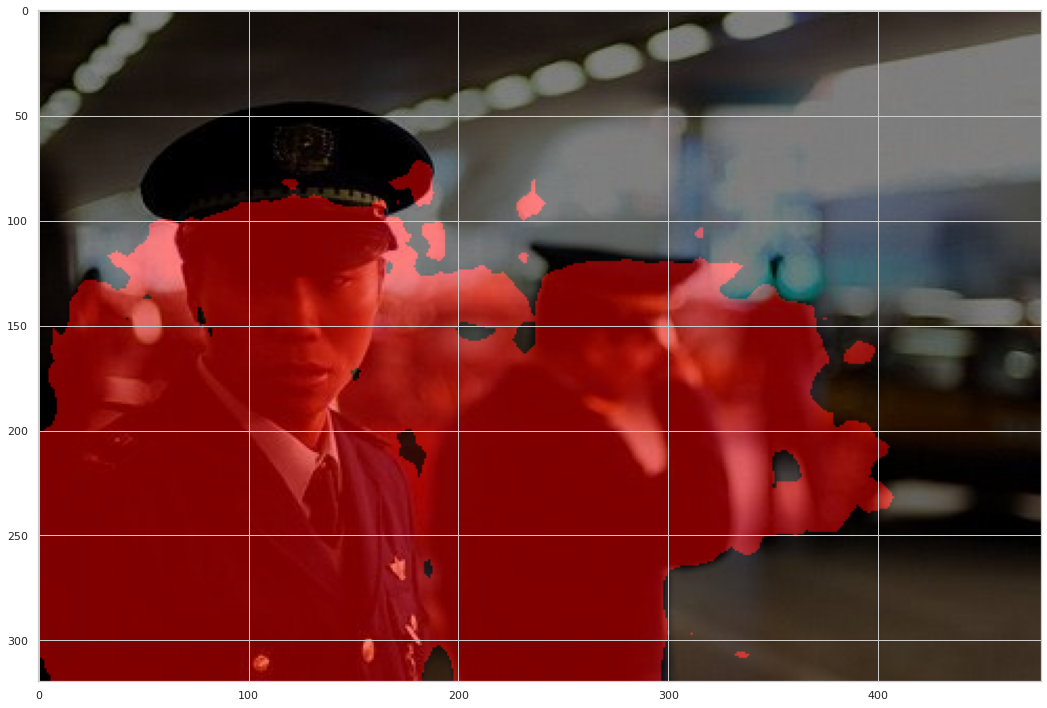

In [30]:
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

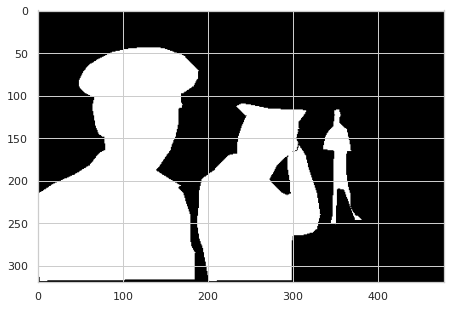

In [31]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/binary-labels/validation/ADE_val_00000011.png')
img[img == 1] = 255
plt.imshow(img, cmap="gray")

In [32]:
img.max()

255

In [33]:
img.min()

0

In [34]:
# print('show video')
# test a video and show the results
video = mmcv.VideoReader('../data/ramp.mp4')

In [35]:
import time

In [36]:
video[1].shape

(1080, 1920, 3)

In [37]:
x = 100

In [38]:
%%time
start = time.time()

for frame in video[:x]: # time - how many frame per sec - metrics acc - IoU
    result = inference_segmentor(model, frame)
    #model.show_result(frame, result)

end = time.time()

CPU times: user 4.32 s, sys: 421 ms, total: 4.74 s
Wall time: 2.18 s


In [39]:
from humanfriendly import format_timespan
aux0 = (end-start)
print("Time:", format_timespan(aux0))
aux1 = aux0/x
print("Time/frame:", format_timespan(aux1))
print("FPS: ", 1/aux1)

Time: 2.18 seconds
Time/frame: 0.02 seconds
FPS:  45.87495987325691


In [40]:
# display the training loss changes
